## Loading of Steinmetz data

includes some visualizations

In [ ]:
# @title Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
pip install -q plotly

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# @title Import matplotlib and set defaults
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval (combined from both notebooks)
import os, requests

# List of filenames to download

fname = [
    'steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz',
    'steinmetz_lfp.npz'
]

fname_all = [
    'steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz',
    'steinmetz_st.npz', 'steinmetz_wav.npz', 'steinmetz_lfp.npz'
]

# Corresponding URLs for the files

url = [
    "https://osf.io/agvxh/download", "https://osf.io/uv3mw/download", "https://osf.io/ehmw2/download",
     "https://osf.io/kx3v9/download"
]
url_all = [
    "https://osf.io/agvxh/download", "https://osf.io/uv3mw/download", "https://osf.io/ehmw2/download",
    "https://osf.io/4bjns/download", "https://osf.io/ugm9v/download", "https://osf.io/kx3v9/download"
]

# Loop over each file and URL to download them
for j in range(len(url)):
  if not os.path.isfile(fname[j]):  # Check if file already exists
    try:
      r = requests.get(url[j])  # Attempt to download the file
    except requests.ConnectionError:
      print(f"!!! Failed to download {fname[j]} due to a connection error !!!")  # Alert which file's download failed on connection error
    else:
      if r.status_code != requests.codes.ok:
        print(f"!!! Failed to download {fname[j]} with status code {r.status_code} !!!")  # Alert which file's download failed and the HTTP status code
      else:
        with open(fname[j], "wb") as fid:  # Write the content to the file if download is successful
          fid.write(r.content)


In [ ]:
# @title Data loading Steinmetz main
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [ ]:
# @title Data loading Steinmetz extra (LFP)

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
#dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
#dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = dat_LFP[11]
print(dat.keys())
#dat = dat_WAV[11]
#print(dat.keys())
#dat = dat_ST[11]
#print(dat.keys())

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp'])


## Data Descriptions

### Decision Making

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

### LFP and waveform

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files.

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels.
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape.
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial.
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.




### EDA given for the Decision Making Dataset

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]



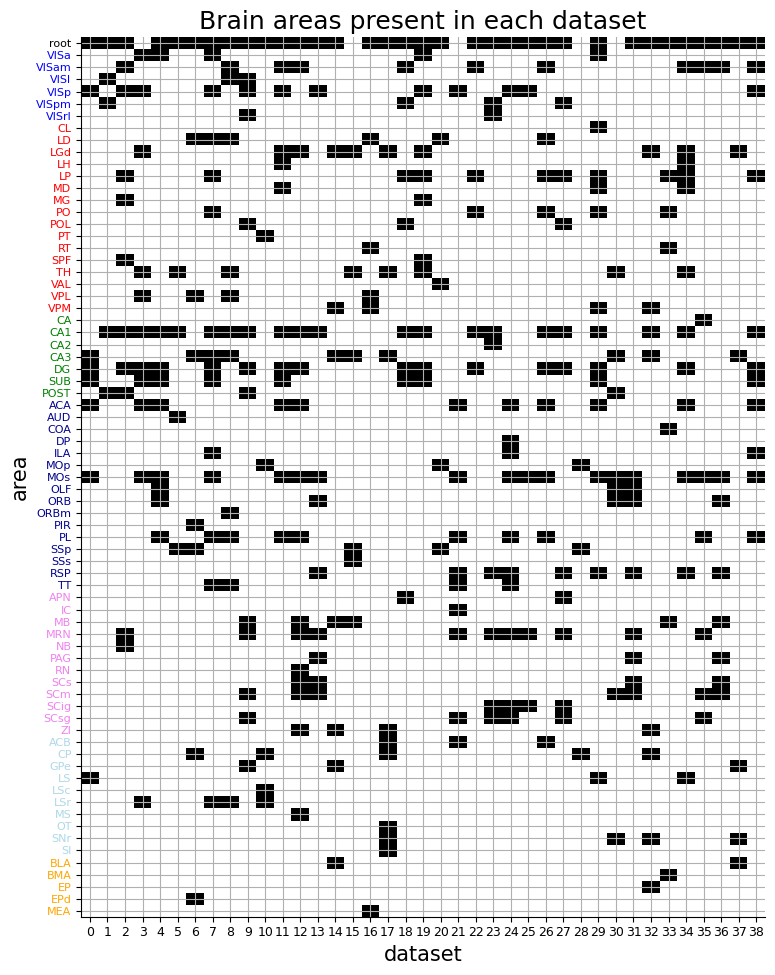

In [ ]:
# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


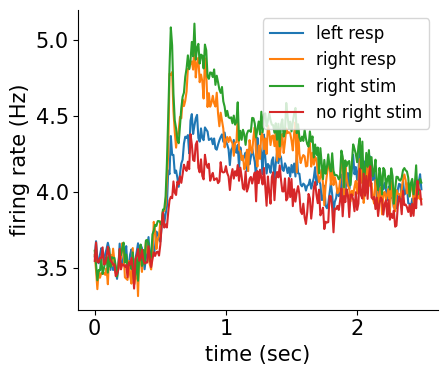

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
nareas =4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

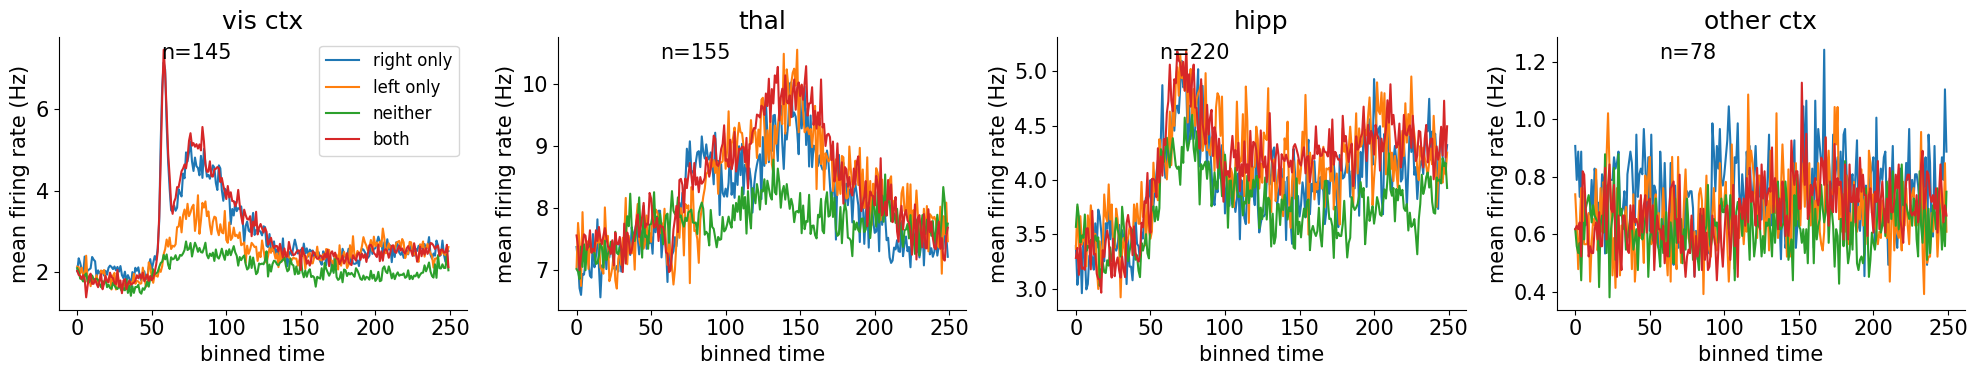

In [ ]:
# @title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()

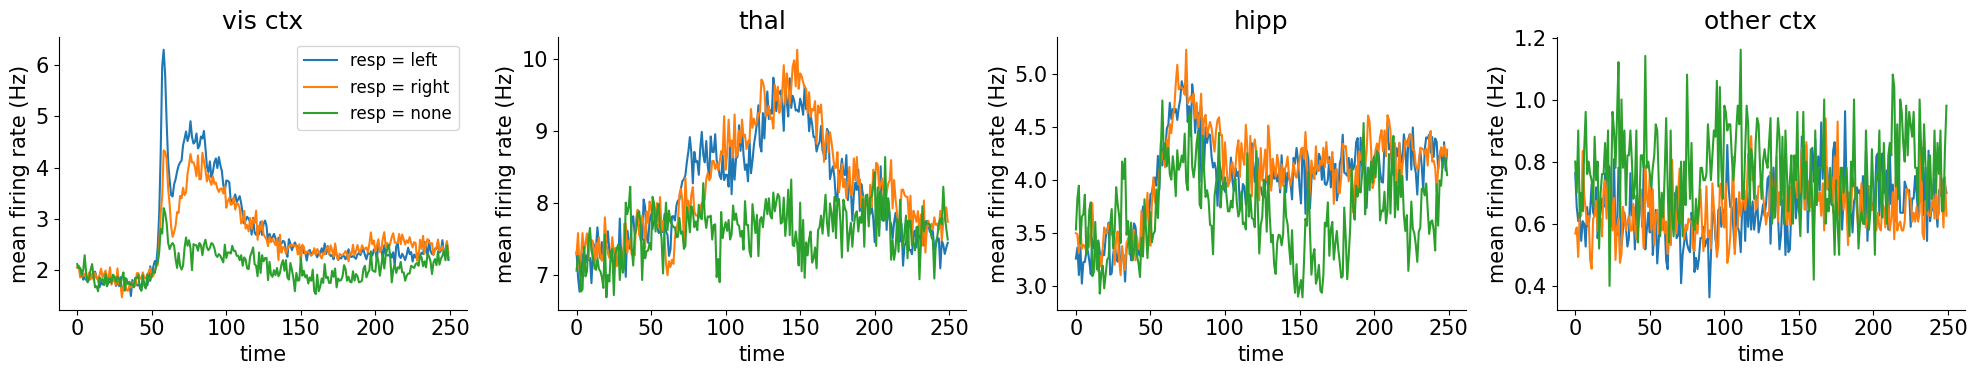

In [ ]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
for i in range(39):
  print(alldat[i]['mouse_name'])

Cori
Cori
Cori
Forssmann
Forssmann
Forssmann
Forssmann
Hench
Hench
Hench
Hench
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Moniz
Moniz
Moniz
Muller
Muller
Muller
Radnitz
Radnitz
Radnitz
Radnitz
Radnitz
Richards
Richards
Richards
Richards
Richards
Tatum
Tatum
Tatum
Tatum
Theiler


# FOR the PROPOSAL


In [ ]:
# Define the brain regions and groups as per your dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [
    ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
]

# Include 'other' brain areas not listed in brain_groups
# We can create a list of all brain areas in the dataset and assign 'other' to those not in brain_groups
all_known_areas = [area for group in brain_groups for area in group]
# Note: 'other' is index len(brain_groups)

nareas = len(brain_groups) + 1  # Adding 1 for 'other' brain areas

# Initialize lists to collect features and labels from all sessions
features_list = []
labels_list = []

# Loop over each session in alldat
for session_idx, dat in enumerate(alldat):
    print(f"Processing session {session_idx + 1}/{len(alldat)}")

    # Extract session data
    spks = dat['spks']  # Shape: neurons x trials x time
    brain_areas = dat['brain_area']  # List of brain areas per neuron
    response = dat['response']  # Responses per trial (-1: left, 1: right, 0: none)
    dt = dat.get('bin_size', 0.01)  # Time bin size in seconds (use 'bin_size' if available)

    NN = len(brain_areas)  # Number of neurons in the session
    barea = (nareas - 1) * np.ones(NN,)  # Initialize brain area indices to 'other' (last index)

    # Assign brain area indices to neurons
    for j in range(len(brain_groups)):
        is_in_group = np.isin(brain_areas, brain_groups[j])
        barea[is_in_group] = j  # Assign index j to neurons in brain_groups[j]

    num_trials = spks.shape[1]

    # Process each trial
    for trial in range(num_trials):
        feature_vector = []

        # Process each brain region (including 'other')
        for j in range(nareas):
            neurons_in_region = np.where(barea == j)[0]
            if len(neurons_in_region) == 0:
                # If no neurons in this brain region, append NaN or a default value
                avg_firing_rate = np.nan  # You can choose to use 0 instead
            else:
                # Extract spike data for neurons in this region and trial
                spikes = spks[neurons_in_region, trial, :]  # Shape: neurons x time
                # Compute average firing rate over all time points
                avg_firing_rate = np.mean(spikes) / dt  # Convert to firing rate (Hz)
            feature_vector.append(avg_firing_rate)

        # Append the feature vector and label to the lists
        features_list.append(feature_vector)
        labels_list.append(response[trial])

# Convert lists to numpy arrays for ML processing
features_array = np.array(features_list)  # Shape: total_trials x nareas
labels_array = np.array(labels_list)      # Shape: total_trials

# Handle missing values (e.g., replace NaNs with zeros or the mean of the feature)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
features_array = imputer.fit_transform(features_array)

# Now, features_array contains average firing rates per brain region per trial
# labels_array contains the responses per trial

# Optional: Convert responses to categorical labels if required by your ML model
# For example, map -1 to 0 (left), 1 to 1 (right), 0 to 2 (none)
label_mapping = {-1: 0, 1: 1, 0: 2}
labels_array = np.array([label_mapping[label] for label in labels_array])

# Your data is now ready for training ML models
print("Feature array shape:", features_array.shape)
print("Labels array shape:", labels_array.shape)

Processing session 1/39
Processing session 2/39
Processing session 3/39
Processing session 4/39
Processing session 5/39
Processing session 6/39
Processing session 7/39
Processing session 8/39
Processing session 9/39
Processing session 10/39
Processing session 11/39
Processing session 12/39
Processing session 13/39
Processing session 14/39
Processing session 15/39
Processing session 16/39
Processing session 17/39
Processing session 18/39
Processing session 19/39
Processing session 20/39
Processing session 21/39
Processing session 22/39
Processing session 23/39
Processing session 24/39
Processing session 25/39
Processing session 26/39
Processing session 27/39
Processing session 28/39
Processing session 29/39
Processing session 30/39
Processing session 31/39
Processing session 32/39
Processing session 33/39
Processing session 34/39
Processing session 35/39
Processing session 36/39
Processing session 37/39
Processing session 38/39
Processing session 39/39
Feature array shape: (10050, 8)
La

In [ ]:
import seaborn as sns

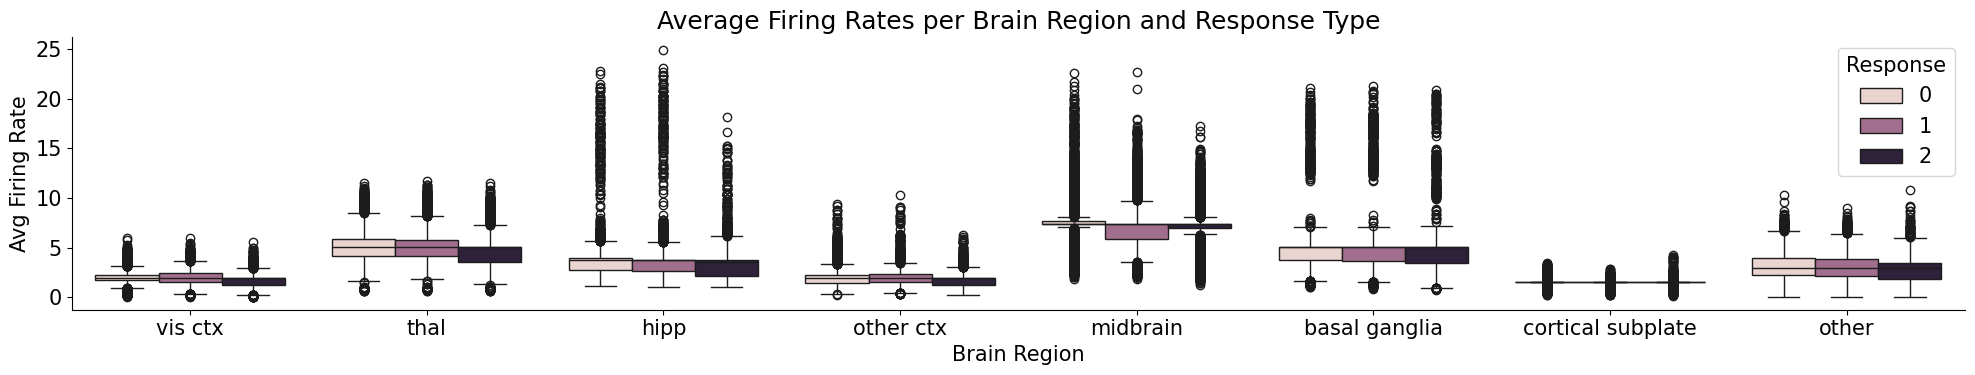

In [ ]:
# Visualize average firing rates per brain region and response type

# Create a DataFrame for visualization
df = pd.DataFrame(features_array, columns=regions[:nareas])
df['Response'] = labels_array

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Response', var_name='Brain Region', value_name='Avg Firing Rate')

# Plot using seaborn
sns.boxplot(data=df_melted, x='Brain Region', y='Avg Firing Rate', hue='Response')
plt.title('Average Firing Rates per Brain Region and Response Type')
plt.show()


In [ ]:
df.head()

vis ctx      thal      hipp  other ctx  midbrain  basal ganglia  \
0  4.110112  5.039583  6.343503   2.037838  7.417903       3.410072   
1  3.919101  5.039583  5.751412   2.218018  7.417903       3.372662   
2  3.269663  5.039583  5.692655   1.632432  7.417903       3.381295   
3  2.649438  5.039583  5.753672   1.517117  7.417903       3.329496   
4  3.685393  5.039583  5.735593   1.944144  7.417903       3.372662   

   cortical subplate     other  Response  
0           1.525245  2.866667         1  
1           1.525245  2.755556         0  
2           1.525245  1.911111         1  
3           1.525245  3.244444         2  
4           1.525245  3.755556         1

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




# Create the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Left', 'Right', 'None']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        Left       0.52      0.51      0.52       675
       Right       0.51      0.48      0.50       674
        None       0.64      0.69      0.66       661

    accuracy                           0.56      2010
   macro avg       0.56      0.56      0.56      2010
weighted avg       0.56      0.56      0.56      2010

Confusion Matrix:
[[344 202 129]
 [218 326 130]
 [ 96 111 454]]


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


In [ ]:
# Initialize a dictionary to store the mean accuracy of each model
model_performance = {}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Create a pipeline for scaling and modeling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, features_array, labels_array, cv=cv, scoring='accuracy')

    # Store mean accuracy
    model_performance[model_name] = cv_scores.mean()

    print(f"{model_name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n")


Training and evaluating Logistic Regression...
Logistic Regression CV Accuracy: 0.4006 ± 0.0133

Training and evaluating SVM...
SVM CV Accuracy: 0.5735 ± 0.0061

Training and evaluating Decision Tree...
Decision Tree CV Accuracy: 0.5824 ± 0.0087

Training and evaluating Random Forest...
Random Forest CV Accuracy: 0.6653 ± 0.0132

Training and evaluating KNN...
KNN CV Accuracy: 0.6501 ± 0.0071

Training and evaluating Gradient Boosting...
Gradient Boosting CV Accuracy: 0.5779 ± 0.0025



<ipython-input-24-2a52e25230f0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CV Accuracy', y='Model', data=performance_df, palette='viridis')


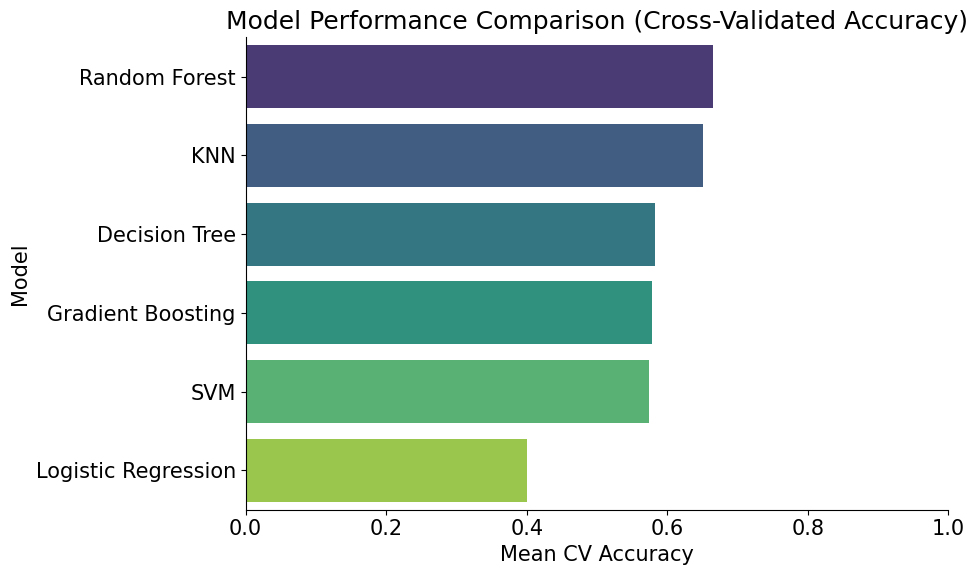

In [ ]:


# Create a DataFrame from the performance dictionary
performance_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'CV Accuracy'])

# Sort the DataFrame by accuracy
performance_df = performance_df.sort_values(by='CV Accuracy', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='CV Accuracy', y='Model', data=performance_df, palette='viridis')
plt.title('Model Performance Comparison (Cross-Validated Accuracy)')
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


In [ ]:
# Initialize a dictionary to store detailed performance metrics
detailed_metrics = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline for scaling and modeling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Get classification report
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right', 'None'], output_dict=True)

    # Store metrics
    detailed_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Left', 'Right', 'None']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


Training Logistic Regression...
Logistic Regression Test Accuracy: 0.4080
              precision    recall  f1-score   support

        Left       0.40      0.32      0.36       675
       Right       0.42      0.39      0.40       674
        None       0.40      0.52      0.45       661

    accuracy                           0.41      2010
   macro avg       0.41      0.41      0.40      2010
weighted avg       0.41      0.41      0.40      2010

Confusion Matrix:
[[215 195 265]
 [167 261 246]
 [154 163 344]]


Training SVM...
SVM Test Accuracy: 0.5592
              precision    recall  f1-score   support

        Left       0.52      0.51      0.52       675
       Right       0.51      0.48      0.50       674
        None       0.64      0.69      0.66       661

    accuracy                           0.56      2010
   macro avg       0.56      0.56      0.56      2010
weighted avg       0.56      0.56      0.56      2010

Confusion Matrix:
[[344 202 129]
 [218 326 130]
 [ 96 11

In [ ]:
# Convert the detailed_metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(detailed_metrics).T  # Transpose to get models as rows

# Display the metrics DataFrame
print(metrics_df)


                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.407960   0.408404  0.407960  0.403860
SVM                  0.559204   0.556036  0.559204  0.557162
Decision Tree        0.592537   0.593000  0.592537  0.592655
Random Forest        0.663682   0.662344  0.663682  0.662896
KNN                  0.653731   0.658832  0.653731  0.655588
Gradient Boosting    0.551244   0.549879  0.551244  0.549424


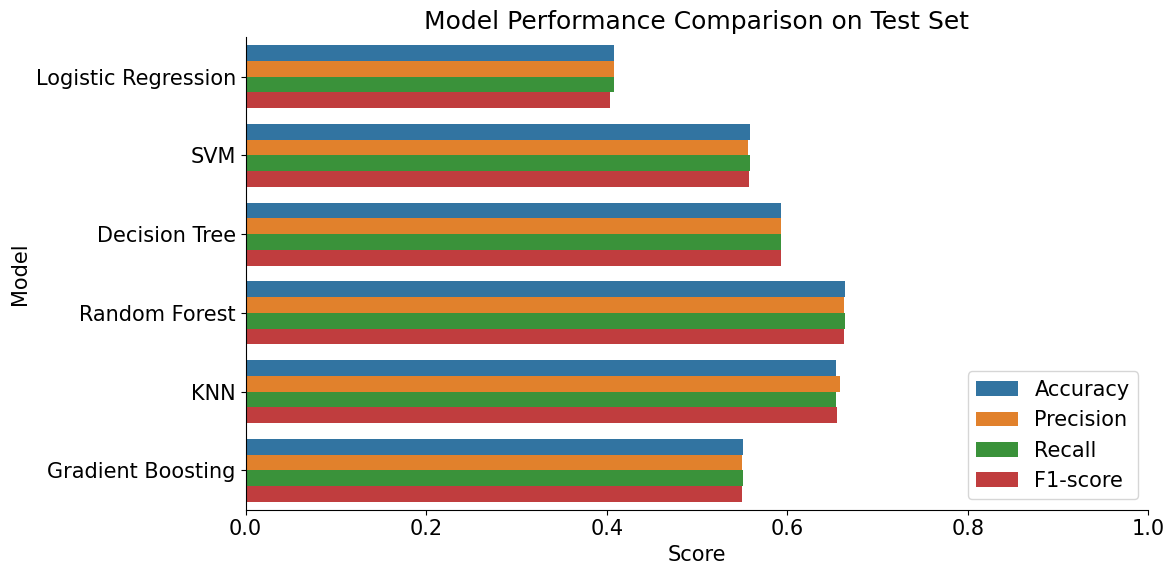

In [ ]:
  # Melt the DataFrame for plotting
metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_melted.rename(columns={'index': 'Model'}, inplace=True)

# Plot the metrics
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_melted)
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Score')
plt.ylabel('Model')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.show()


---

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, TimeDistributed, BatchNormalization, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



# Include 'other' brain areas not listed in brain_groups
all_known_areas = [area for group in brain_groups for area in group]
nareas = len(brain_groups) + 1  # Adding 1 for 'other' brain areas

# Initialize lists to collect features and labels from all sessions
X_lstm_list = []
y_lstm_list = []

# Loop over each session in alldat
for session_idx, dat in enumerate(alldat):
    print(f"Processing session {session_idx + 1}/{len(alldat)}")

    # Extract session data
    spks = dat['spks']  # Shape: neurons x trials x time
    brain_areas = dat['brain_area']  # List of brain areas per neuron
    response = dat['response']  # Responses per trial (-1: left, 1: right, 0: none)
    dt = dat.get('bin_size', 0.01)  # Time bin size in seconds (use 'bin_size' if available)

    NN = len(brain_areas)  # Number of neurons
    barea = (nareas - 1) * np.ones(NN,)  # Initialize brain area indices to 'other' (last index)

    # Assign brain area indices to neurons
    for j in range(len(brain_groups)):
        is_in_group = np.isin(brain_areas, brain_groups[j])
        barea[is_in_group] = j  # Assign index j to neurons in brain_groups[j]

    num_trials = spks.shape[1]
    time_steps = spks.shape[2]

    # Process each trial
    for trial in range(num_trials):
        # Initialize a 2D array for this trial: time_steps x nareas
        trial_data = np.zeros((time_steps, nareas))

        # Process each brain region (including 'other')
        for j in range(nareas):
            neurons_in_region = np.where(barea == j)[0]
            if len(neurons_in_region) == 0:
                # If no neurons in this brain region, fill with zeros
                trial_data[:, j] = 0.0
            else:
                # Extract spike data for neurons in this region and trial
                spikes = spks[neurons_in_region, trial, :]  # Shape: neurons x time_steps
                # Compute average firing rate over neurons at each time step
                avg_spikes = np.mean(spikes, axis=0) / dt  # Firing rate per time step
                trial_data[:, j] = avg_spikes

        # Append the trial data and label
        X_lstm_list.append(trial_data)  # Shape: time_steps x nareas
        y_lstm_list.append(response[trial])

# Convert labels to array
y_lstm = np.array(y_lstm_list)

# Map responses to labels
label_mapping = {-1: 0, 1: 1, 0: 2}  # 0: Left, 1: Right, 2: None
y_lstm = np.array([label_mapping[label] for label in y_lstm])

# Determine the maximum sequence length
max_time_steps = max(trial.shape[0] for trial in X_lstm_list)

# Pad sequences to the maximum length
X_lstm_padded = pad_sequences(
    X_lstm_list,
    maxlen=max_time_steps,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0  # Value to pad with
)

print("Padded LSTM Input shape:", X_lstm_padded.shape)
print("LSTM Output shape:", y_lstm.shape)

# One-hot encode the labels for categorical cross-entropy loss
num_classes = 3
y_lstm_categorical = to_categorical(y_lstm, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm_padded, y_lstm_categorical, test_size=0.2, random_state=42, stratify=y_lstm)

Processing session 1/39
Processing session 2/39
Processing session 3/39
Processing session 4/39
Processing session 5/39
Processing session 6/39
Processing session 7/39
Processing session 8/39
Processing session 9/39
Processing session 10/39
Processing session 11/39
Processing session 12/39
Processing session 13/39
Processing session 14/39
Processing session 15/39
Processing session 16/39
Processing session 17/39
Processing session 18/39
Processing session 19/39
Processing session 20/39
Processing session 21/39
Processing session 22/39
Processing session 23/39
Processing session 24/39
Processing session 25/39
Processing session 26/39
Processing session 27/39
Processing session 28/39
Processing session 29/39
Processing session 30/39
Processing session 31/39
Processing session 32/39
Processing session 33/39
Processing session 34/39
Processing session 35/39
Processing session 36/39
Processing session 37/39
Processing session 38/39
Processing session 39/39
Padded LSTM Input shape: (10050, 2

In [ ]:
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # You can monitor 'val_loss' or 'val_accuracy'
    patience=5,          # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restores the weights of the best epoch
)


In [ ]:

# Build the LSTM model
model = Sequential()

# Add the Input layer
model.add(Input(shape=(X_lstm_padded.shape[1], X_lstm_padded.shape[2])))

# Add the Masking layer to handle padded values
model.add(Masking(mask_value=0.0))

# Add the LSTM layer
model.add(LSTM(64, return_sequences=False))

# Move BatchNormalization here
model.add(BatchNormalization())

# Add the Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 250, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 20,995 (82.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.3956 - loss: 1.1242 - val_accuracy: 0.4095 - val_loss: 1.0684
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.4495 - loss: 1.0327 - val_accuracy: 0.4617 - val_loss: 1.0334
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.4960 - loss: 0.9820 - val_accuracy: 0.4468 - val_loss: 1.0345
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.4879 - loss: 0.9898 - val_accuracy: 0.4672 - val_loss: 1.0078
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.5140 - loss: 0.9532 - val_accuracy: 0.4955 - val_loss: 0.9926
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.5330 - loss: 0.9178 - val_accuracy: 0.4264 - val_loss: 1.1359
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.5058 - loss: 0.9607 - val_accuracy: 0.4896 - val_loss: 0.9765
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.5364 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.407960   0.408404  0.407960  0.403860
SVM                  0.559204   0.556036  0.559204  0.557162
Decision Tree        0.592537   0.593000  0.592537  0.592655
Random Forest        0.663682   0.662344  0.663682  0.662896
KNN                  0.653731   0.658832  0.653731  0.655588
Gradient Boosting    0.551244   0.549879  0.551244  0.549424
LSTM                 0.692537   0.688597  0.692537  0.690037


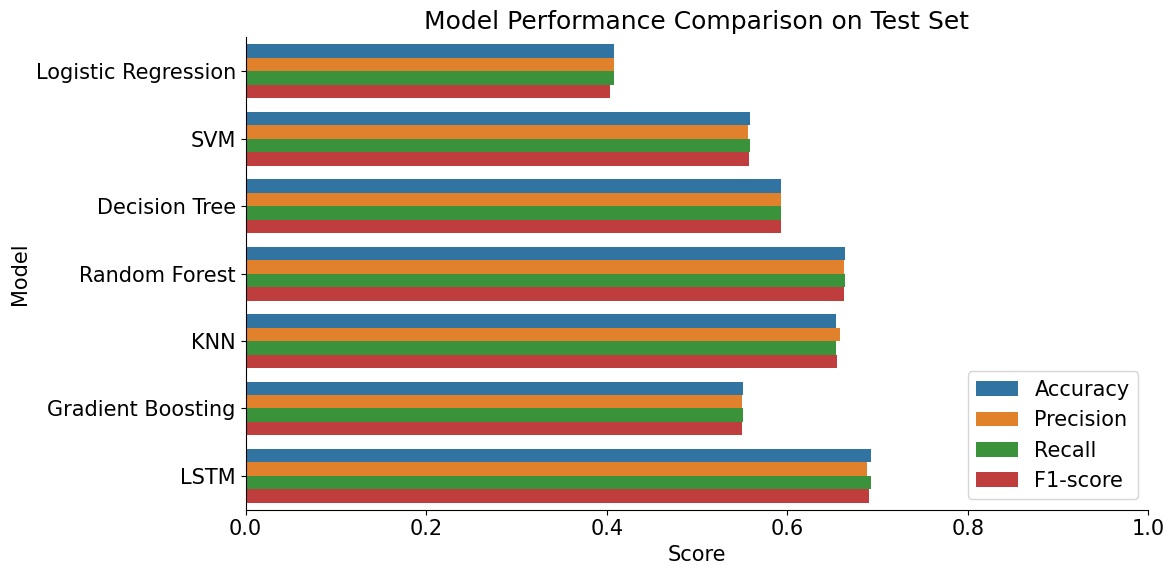

In [ ]:
# Predict on the test data
y_pred_lstm = np.argmax(model.predict(X_test), axis=1)
y_test_lstm = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)

# Get classification report
report_lstm = classification_report(y_test_lstm, y_pred_lstm, target_names=['Left', 'Right', 'None'], output_dict=True)

# Store metrics
detailed_metrics['LSTM'] = {
    'Accuracy': accuracy_lstm,
    'Precision': report_lstm['weighted avg']['precision'],
    'Recall': report_lstm['weighted avg']['recall'],
    'F1-score': report_lstm['weighted avg']['f1-score']
}

# Convert the detailed_metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(detailed_metrics).T  # Transpose to get models as rows

# Display the metrics DataFrame
print(metrics_df)

# Melt the DataFrame for plotting
metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_melted.rename(columns={'index': 'Model'}, inplace=True)

# Plot the metrics
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_melted)
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Score')
plt.ylabel('Model')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.show()

In [ ]:
!pip install shap==0.41.0

# For TensorFlow models, use DeepExplainer
from shap import DeepExplainer

# Prepare a small sample due to computational load
X_sample = X_test[:100]

# Create an explainer
explainer = DeepExplainer(model, X_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Since the output is multi-dimensional, we might need to average over time steps
# For simplicity, let's sum SHAP values over time steps

# Sum over time steps
shap_values_summed = np.sum(shap_values[0], axis=1)  # For class 0 (Left)

# Create a DataFrame
importance_df_lstm = pd.DataFrame({
    'Brain Region': regions[:nareas],
    'Importance': np.mean(np.abs(shap_values_summed), axis=0)
})

# Sort and plot
importance_df_lstm = importance_df_lstm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Brain Region', data=importance_df_lstm, palette='inferno')
plt.title('Feature Importance from LSTM SHAP Values')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Brain Region')
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize LDA
lda = LinearDiscriminantAnalysis(n_components=2)  # Adjust n_components as needed

# Fit and transform the data
X_lda = lda.fit_transform(features_array, labels_array)

# Plot the LDA components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=labels_array, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['Left', 'Right', 'None'])
plt.title('LDA of Brain Region Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()


In [ ]:
# Get the coefficients
coefficients_lda = lda.coef_

# For multiclass, you can average the absolute values
feature_importance_lda = np.mean(np.abs(coefficients_lda), axis=0)

# Create DataFrame
importance_df_lda = pd.DataFrame({
    'Brain Region': regions[:nareas],
    'Importance': feature_importance_lda
})

# Sort and plot
importance_df_lda = importance_df_lda.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Brain Region', data=importance_df_lda, palette='plasma')
plt.title('Feature Importance from LDA Coefficients')
plt.xlabel('Average Absolute Coefficient')
plt.ylabel('Brain Region')
plt.show()


---

In [ ]:
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

# Define a function to plot data for a given session
def plot_session_data(session_idx):
    dat = alldat[session_idx]
    spks = dat['spks']
    brain_areas = dat['brain_area']
    response = dat['response']
    dt = dat.get('bin_size', 0.01)
    time = np.arange(spks.shape[2]) * dt  # Time vector

    NN = len(brain_areas)
    nareas = len(brain_groups)
    barea = nareas * np.ones(NN,)

    # Assign brain area indices to neurons
    for j in range(nareas):
        is_in_group = np.isin(brain_areas, brain_groups[j])
        barea[is_in_group] = j

    # Plot average firing rates over time for each brain region
    plt.figure(figsize=(20, 4))
    for j in range(nareas):
        neurons_in_region = np.where(barea == j)[0]
        if len(neurons_in_region) == 0:
            continue
        avg_spks_left = spks[neurons_in_region][:, response == -1, :].mean(axis=(0, 1)) / dt
        avg_spks_right = spks[neurons_in_region][:, response == 1, :].mean(axis=(0, 1)) / dt
        avg_spks_none = spks[neurons_in_region][:, response == 0, :].mean(axis=(0, 1)) / dt

        plt.subplot(1, nareas, j + 1)
        plt.plot(time, avg_spks_left, label='Left')
        plt.plot(time, avg_spks_right, label='Right')
        plt.plot(time, avg_spks_none, label='None')
        plt.title(regions[j])
        plt.xlabel('Time (s)')
        plt.ylabel('Firing Rate (Hz)')
        if j == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

# Create an interactive widget
session_slider = IntSlider(min=0, max=len(alldat)-1, step=1, description='Session Index')

interact(plot_session_data, session_idx=session_slider);


---

---

---


In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response) == np.sign(vis_left - vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time')
  if j == 0:
    ax.set(ylabel='trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.show()

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
plt.show()

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])

  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p == 0)].mean(axis=(0, 1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j == 0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)

## EDA given for the Extra (LFP) Dataset

## Data Checks

In [ ]:
# Check for missing values in the dataset
print("Checking for missing values in the dataset...")
missing_data_counts = {key: np.sum(pd.isna(value)) for key, value in dat.items()}
print("Missing data counts by key:", missing_data_counts)

# Display basic information about the dataset
print("\nDataset Information:")
for key in dat:
    print(f"Key: {key}, Shape: {np.array(dat[key]).shape}, Dtype: {np.array(dat[key]).dtype}")


In [ ]:
#if you wanted CSV for df
dat_LFP_df = pd.DataFrame(dat_LFP)

In [ ]:
#looking at one entry
print(dat_LFP_df[0:1][0][0])

In [ ]:
dat_LFP[1].keys()

In [ ]:
len(dat_LFP)

In [ ]:
dat_LFP[1]['brain_area_lfp']

In [ ]:
dat_LFP[11]['brain_area_lfp']

In [ ]:
len(dat_LFP[1]['lfp'])

In [ ]:
len(dat_LFP[1]['lfp_passive'])

4

In [ ]:
dat_LFP[1]['lfp'][0]

array([[  10.20082501,   11.94550586,    5.91359097, ...,   12.2646548 ,
           6.33912288,   13.39231437],
       [   4.41663048,   14.08684325,    4.19322623, ...,   16.43790708,
          -2.28549718,    6.69322623],
       [   3.63851498,    9.68106817,    3.33000434, ...,  -11.70191055,
         -11.01042119,   -5.62744247],
       ...,
       [   2.09531046,   -8.98979592,  -22.5961789 , ...,  -27.74511507,
         -15.02171081,    5.435736  ],
       [-257.06730352, -207.19496309, -160.29070777, ...,  -59.28006947,
         -66.96092054,  -31.1524099 ],
       [ -19.63547547,  -24.00781589,  -22.50781589, ...,   18.72622666,
          19.5134607 ,   13.5134607 ]])

In [ ]:
len(dat_LFP[1]['lfp'][0])

251

## Synching Data

Proper synchronization is crucial for accurate analysis, especially when dealing with time-series data like LFPs that are linked to behavioral events. We will align the LFP data with the timestamps of stimulus presentations and behavioral responses to ensure that our analysis can accurately correlate neural activity with cognitive and motor functions.


In [ ]:
alldat[0].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

d

In [ ]:
alldat.shape

(39,)

In [ ]:
dat_LFP[11].keys()

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp'])

In [ ]:
dat_LFP.shape

(39,)

In [ ]:
# Initialize an empty list to store the combined data
combined_data = []

# Loop through each session index
for i in range(dat_LFP.shape[0]):
    # Create a new dictionary that merges the two dictionaries from the same session
    combined_session_data = {**dat_LFP[i], **alldat[i]}  # Using ** to unpack and merge dictionaries

    # Add the combined dictionary to the list
    combined_data.append(combined_session_data)

# Optionally convert combined_data to an ndarray if needed
combined_data = np.array(combined_data)

# Example to check the combined data
print("Keys in combined data for session 1:", combined_data[0].keys())
print("Shape of LFP data in session 1:", combined_data[0]['lfp'].shape)

Keys in combined data for session 1: dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
Shape of LFP data in session 1: (7, 214, 250)


### Filtering Data for Cori

In [ ]:
for i in range(38):
    print(combined_data[i]['mouse_name'])

Cori
Cori
Cori
Forssmann
Forssmann
Forssmann
Forssmann
Hench
Hench
Hench
Hench
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Lederberg
Moniz
Moniz
Moniz
Muller
Muller
Muller
Radnitz
Radnitz
Radnitz
Radnitz
Radnitz
Richards
Richards
Richards
Richards
Richards
Tatum
Tatum
Tatum
Tatum


In [ ]:
cori_data = []
for i in range(38):
  if combined_data[i]['mouse_name'] == 'Cori':
    cori_data.append(combined_data[i])

cori_data = np.array(cori_data)
print(cori_data.shape)

(3,)


In [ ]:
combined_data[2]['brain_area_lfp']

['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']

In [ ]:
dat_LFP[2]['brain_area_lfp']

['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']

In [ ]:
cori_data[2]['brain_area_lfp']

['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']

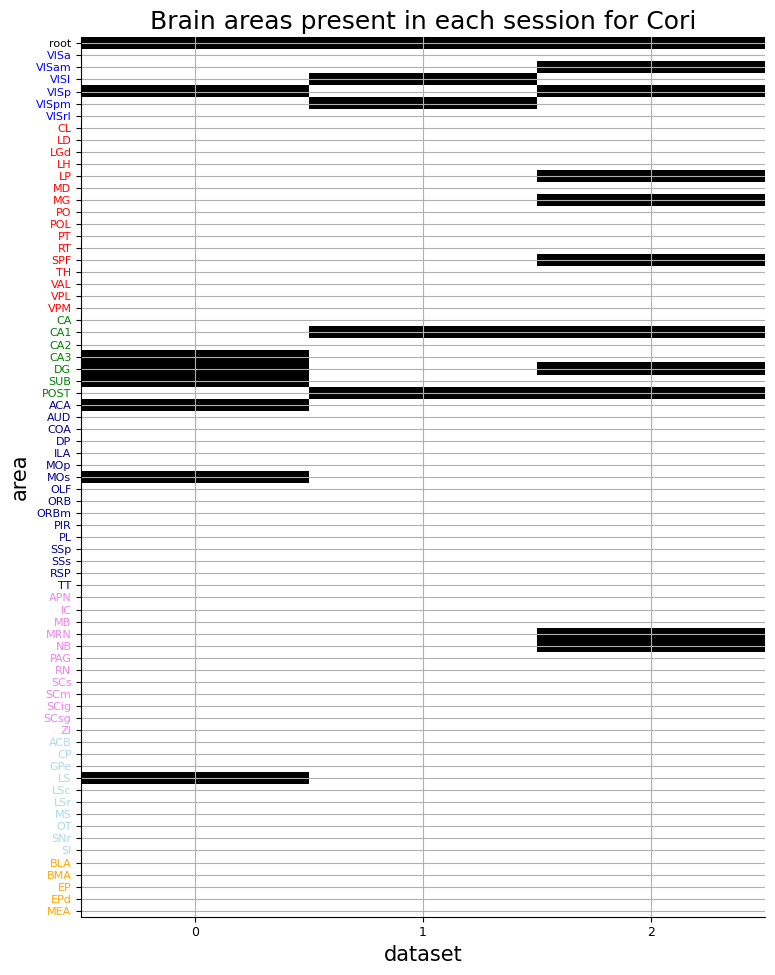

In [ ]:
# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(cori_data)), dtype=bool)
for j, d in enumerate(cori_data):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(cori_data)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each session for Cori")
plt.grid(True)
plt.show()

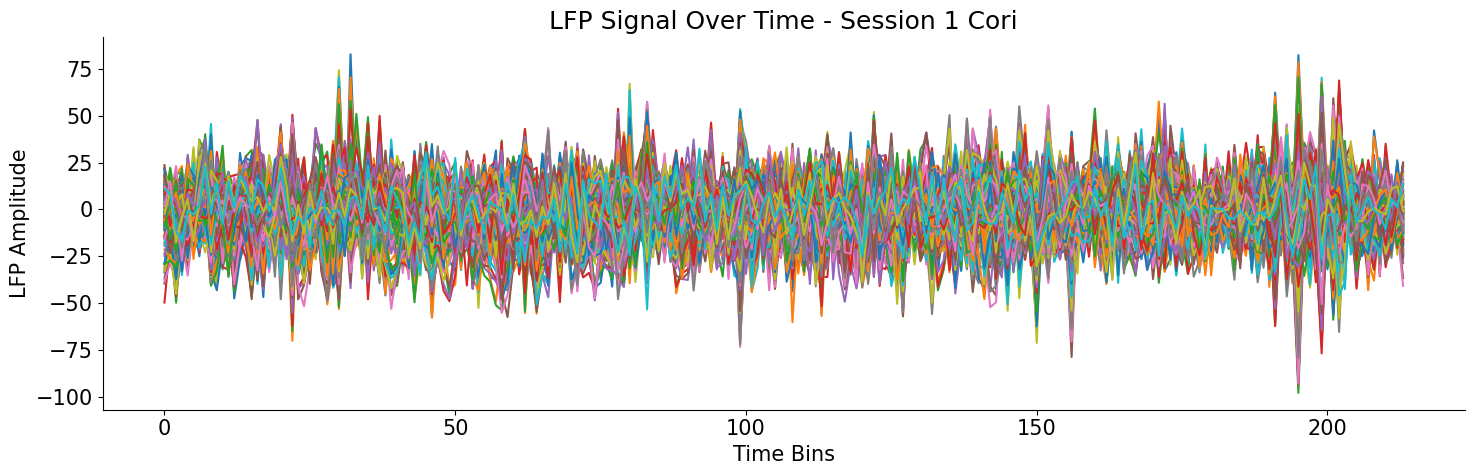

In [ ]:
# Visualizing LFP data for a specific session
session_index = 0  # Example session index
lfp_data = cori_data[session_index]['lfp']
plt.figure(figsize=(15, 5))
plt.plot(lfp_data[0, :, :])  # Plotting LFP data from the first electrode
plt.title(f'LFP Signal Over Time - Session {session_index+1} Cori')
plt.xlabel('Time Bins')
plt.ylabel('LFP Amplitude')
plt.show()

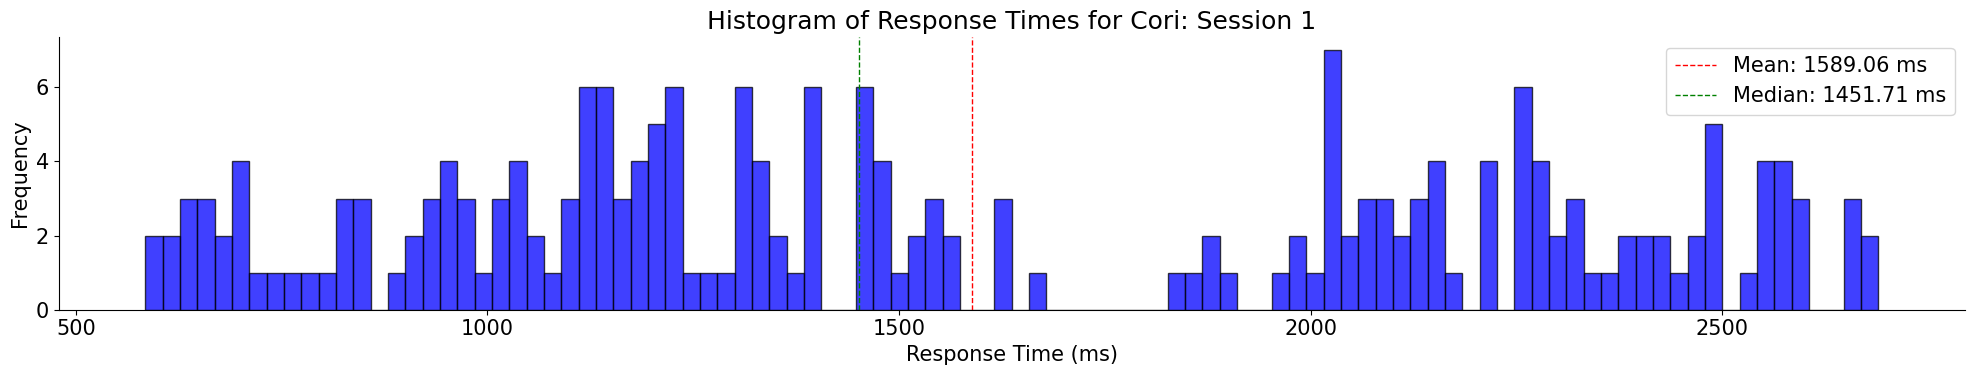

In [ ]:
data = cori_data[0]['response_time'].flatten() * 1000

# Calculate mean, median, and mode
mean_value = np.mean(data)
median_value = np.median(data)


# Plot histogram
plt.hist(data, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Add lines for mean, median, and mode
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f} ms')


# Add labels and title
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times for Cori: Session 1')
plt.legend()

# Show plot
plt.show()

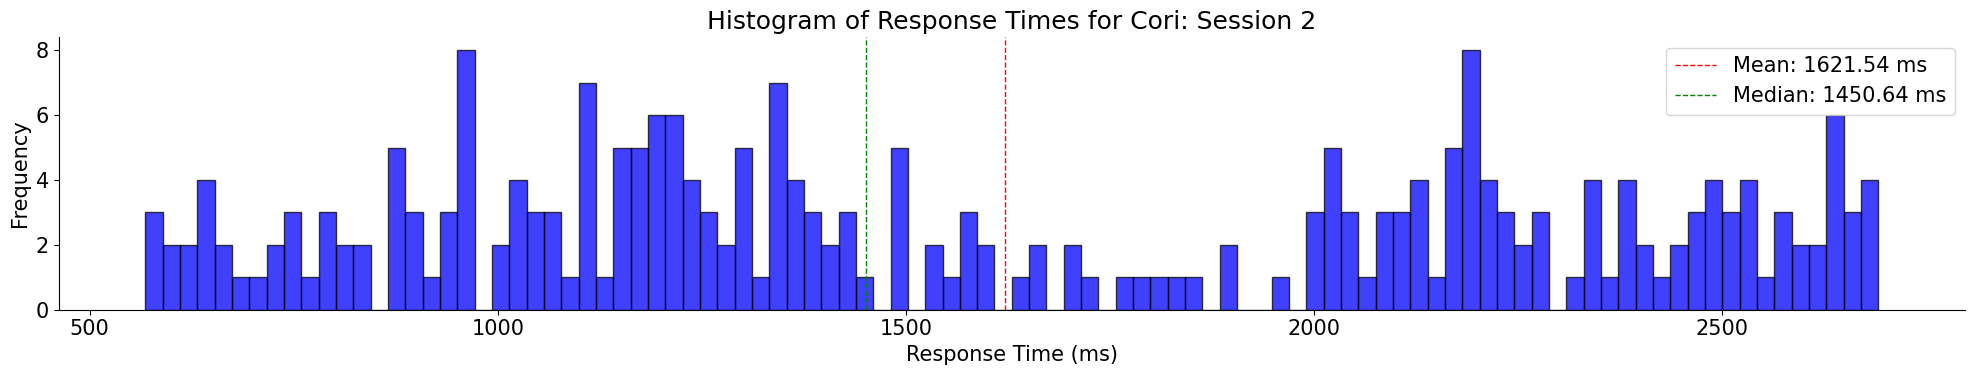

In [ ]:
data = cori_data[1]['response_time'].flatten() * 1000

# Calculate mean, median, and mode
mean_value = np.mean(data)
median_value = np.median(data)


# Plot histogram
plt.hist(data, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Add lines for mean, median, and mode
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f} ms')


# Add labels and title
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times for Cori: Session 2')
plt.legend()

# Show plot
plt.show()

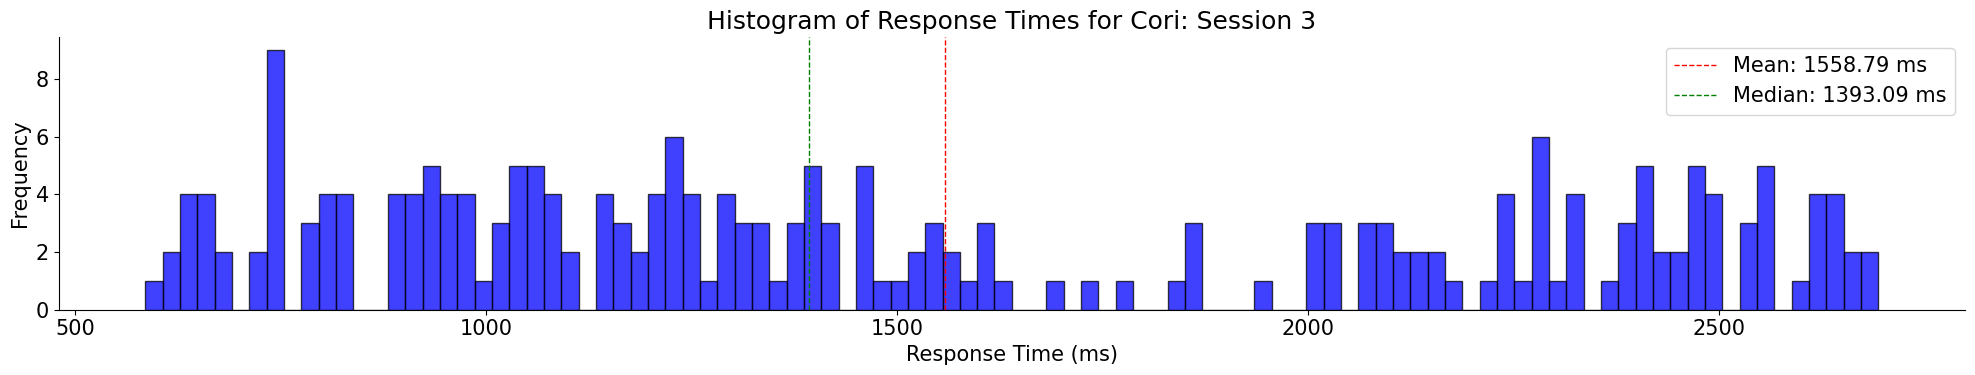

In [ ]:
data = cori_data[2]['response_time'].flatten() * 1000

# Calculate mean, median, and mode
mean_value = np.mean(data)
median_value = np.median(data)


# Plot histogram
plt.hist(data, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Add lines for mean, median, and mode
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f} ms')


# Add labels and title
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times for Cori: Session 3')
plt.legend()

# Show plot
plt.show()

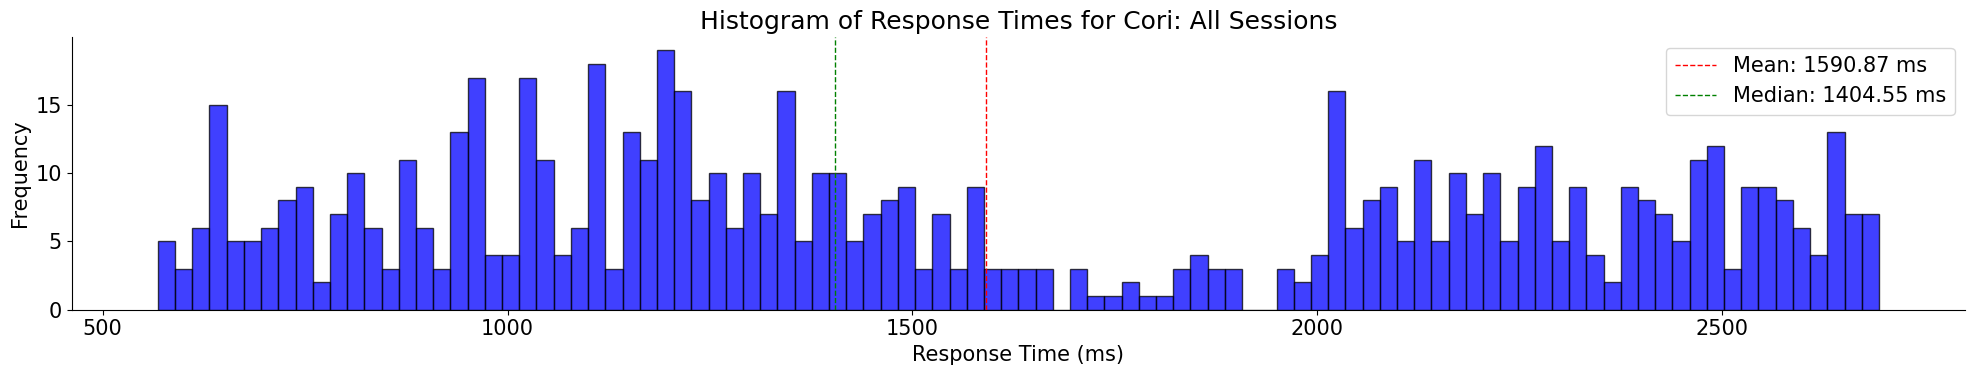

In [ ]:
# Assuming cori_data is a list of dictionaries with 'response_time' as a key
sessions = [cori_data[0], cori_data[1], cori_data[2]]

# Combine the response times from all sessions
all_data = np.concatenate([session['response_time'].flatten() for session in sessions]) * 1000

# Calculate mean and median for all sessions combined
mean_value = np.mean(all_data)
median_value = np.median(all_data)

# Plot histogram
plt.hist(all_data, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Add lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f} ms')

# Add labels and title
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times for Cori: All Sessions')
plt.legend()

# Show plot
plt.show()


In [ ]:
def convert_to_units(time_in_seconds):
    """Converts time from seconds to units where 100ms is 1 unit."""
    return time_in_seconds * 100

In [ ]:
def time_range(time_in_units):

  range_start = time_in_units -10
  range_end = time_in_units +10

  return range_start, range_end

In [ ]:
# def mark_events(response_units, reward_units):
#     """Marks specific time events based on the units."""
#     events = {
#         'stim_onset': 50,  # Equivalent to 500ms
#         'go_cue': 100 + reward_units + 5  # Base go_cue at 100 units plus delay from reward_units
#     }
#     return events

In [ ]:
cori_data[0].keys()

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

### Contrast

* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.

In [ ]:
cori_data[0]['contrast_right']

array([0.  , 0.5 , 0.5 , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ,
       0.  , 0.25, 0.  , 0.  , 1.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.25, 1.  , 1.  , 0.  , 0.5 ,
       0.  , 0.  , 0.  , 0.  , 0.25, 1.  , 0.  , 0.25, 0.5 , 1.  , 0.  ,
       0.  , 0.5 , 1.  , 0.  , 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.5 ,
       0.5 , 0.25, 1.  , 0.5 , 0.5 , 1.  , 1.  , 0.  , 0.5 , 0.  , 0.5 ,
       0.25, 0.  , 1.  , 0.5 , 0.  , 0.25, 0.25, 1.  , 1.  , 0.  , 1.  ,
       0.25, 0.5 , 0.  , 1.  , 1.  , 1.  , 1.  , 0.25, 0.  , 0.  , 0.  ,
       0.5 , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.5 , 0.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.  ,
       0.25, 1.  , 1.  , 1.  , 1.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25,
       0.  , 1.  , 0.5 , 0.5 , 0.  , 0.5 , 1.  , 0.  , 0.  , 0.25, 0.  ,
       0.5 , 0.5 , 1.  , 0.5 , 0.  , 0.25, 0.  , 0.5 , 0.25, 0.5 , 0.5 ,
       0.5 , 1.  , 0.  , 0.5 , 0.  , 0.  , 0.5 , 0.

In [ ]:
cori_data[0]['contrast_left']

array([1.  , 0.  , 1.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 1.  , 0.5 ,
       0.  , 0.5 , 1.  , 0.5 , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.25, 0.  , 1.  ,
       0.5 , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.25, 1.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.5 , 0.25, 0.5 , 0.  , 0.  , 0.  , 1.  , 0.5 ,
       0.5 , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.  , 0.  , 1.  , 0.  ,
       0.25, 0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.5 , 0.  , 1.  , 1.  ,
       0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.  , 1.  , 0.5 , 0.  , 0.5 ,
       0.  , 0.5 , 1.  , 0.25, 0.5 , 0.5 , 0.  , 1.  , 0.  , 0.25, 0.25,
       0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.  , 0.5 , 0.5 , 0.  , 0.5 , 0.  ,
       0.5 , 0.  , 1.  , 0.25, 1.  , 0.  , 0.25, 1.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.  , 0.5 , 0.  , 0.  , 1.  , 0.5 , 0.  ,
       0.25, 0.5 , 0.  , 0.25, 0.5 , 0.  , 0.5 , 1.

### Response

- left turn = -1

- no movement = 0

- right turn = 1

>> `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a

In [ ]:
cori_data[0]['response']

array([ 1., -1.,  1.,  0.,  1.,  1., -1., -1.,  0.,  1.,  1.,  0.,  1.,
        1.,  1., -1.,  0., -1., -1., -1.,  0.,  1.,  1.,  0.,  1.,  1.,
        0., -1.,  1., -1., -1.,  0., -1.,  1., -1.,  0.,  0., -1., -1.,
        1.,  1., -1., -1., -1.,  0., -1., -1.,  1., -1.,  1., -1., -1.,
        0.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,  1.,
       -1., -1.,  0., -1.,  0.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
       -1.,  0.,  0.,  1., -1., -1.,  1.,  0.,  0.,  1., -1.,  1.,  1.,
        1.,  1.,  0., -1.,  1., -1.,  0.,  1.,  0., -1.,  1., -1.,  0.,
       -1.,  0., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,
        1.,  0.,  1.,  0.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  0.,
       -1.,  0., -1., -1., -1.,  0.,  0.,  1.,  0., -1.,  1., -1., -1.,
        1., -1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1., -1.,  0., -1.,
        1., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0., -1.,  1.,  1.,  1.,  0.,  0

In [ ]:
# Get unique values and their counts
unique_response_values, response_counts = np.unique(cori_data[0]['response'], return_counts=True)

# Print results
for value, count in zip(unique_response_values, response_counts):
  print(f"Value: {value}, Count: {count}")

Value: -1.0, Count: 69
Value: 0.0, Count: 74
Value: 1.0, Count: 71


### Feedback type

- -1 : Noise burst
- +1 : Water reward

>> `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  

In [ ]:
cori_data[0]['feedback_type']

array([ 1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1

In [ ]:
# Get unique values and their counts
unique_feedback_values, feedback_counts = np.unique(cori_data[0]['feedback_type'], return_counts=True)

# Print results
for value, count in zip(unique_feedback_values, feedback_counts):
  print(f"Value: {value}, Count: {count}")

Value: -1.0, Count: 73
Value: 1.0, Count: 141


In [ ]:
# Get unique values and their counts
unique_feedback_values, feedback_counts = np.unique(cori_data[1]['feedback_type'], return_counts=True)

# Print results
for value, count in zip(unique_feedback_values, feedback_counts):
  print(f"Value: {value}, Count: {count}")

Value: -1.0, Count: 92
Value: 1.0, Count: 159


In [ ]:
# Get unique values and their counts
unique_feedback_values, feedback_counts = np.unique(cori_data[2]['feedback_type'], return_counts=True)

# Print results
for value, count in zip(unique_feedback_values, feedback_counts):
  print(f"Value: {value}, Count: {count}")

Value: -1.0, Count: 77
Value: 1.0, Count: 151


### LFP data

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels.

In [ ]:
cori_data[0]['brain_area_lfp']

['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']

In [ ]:
cori_data[1]['brain_area_lfp']

['CA1', 'VISl', 'POST', 'VISpm']

In [ ]:
cori_data[2]['brain_area_lfp']

['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']

In [ ]:
cori_data[0]['lfp'].shape

(7, 214, 250)

# **Event-Related Potential (ERP) Analysis**


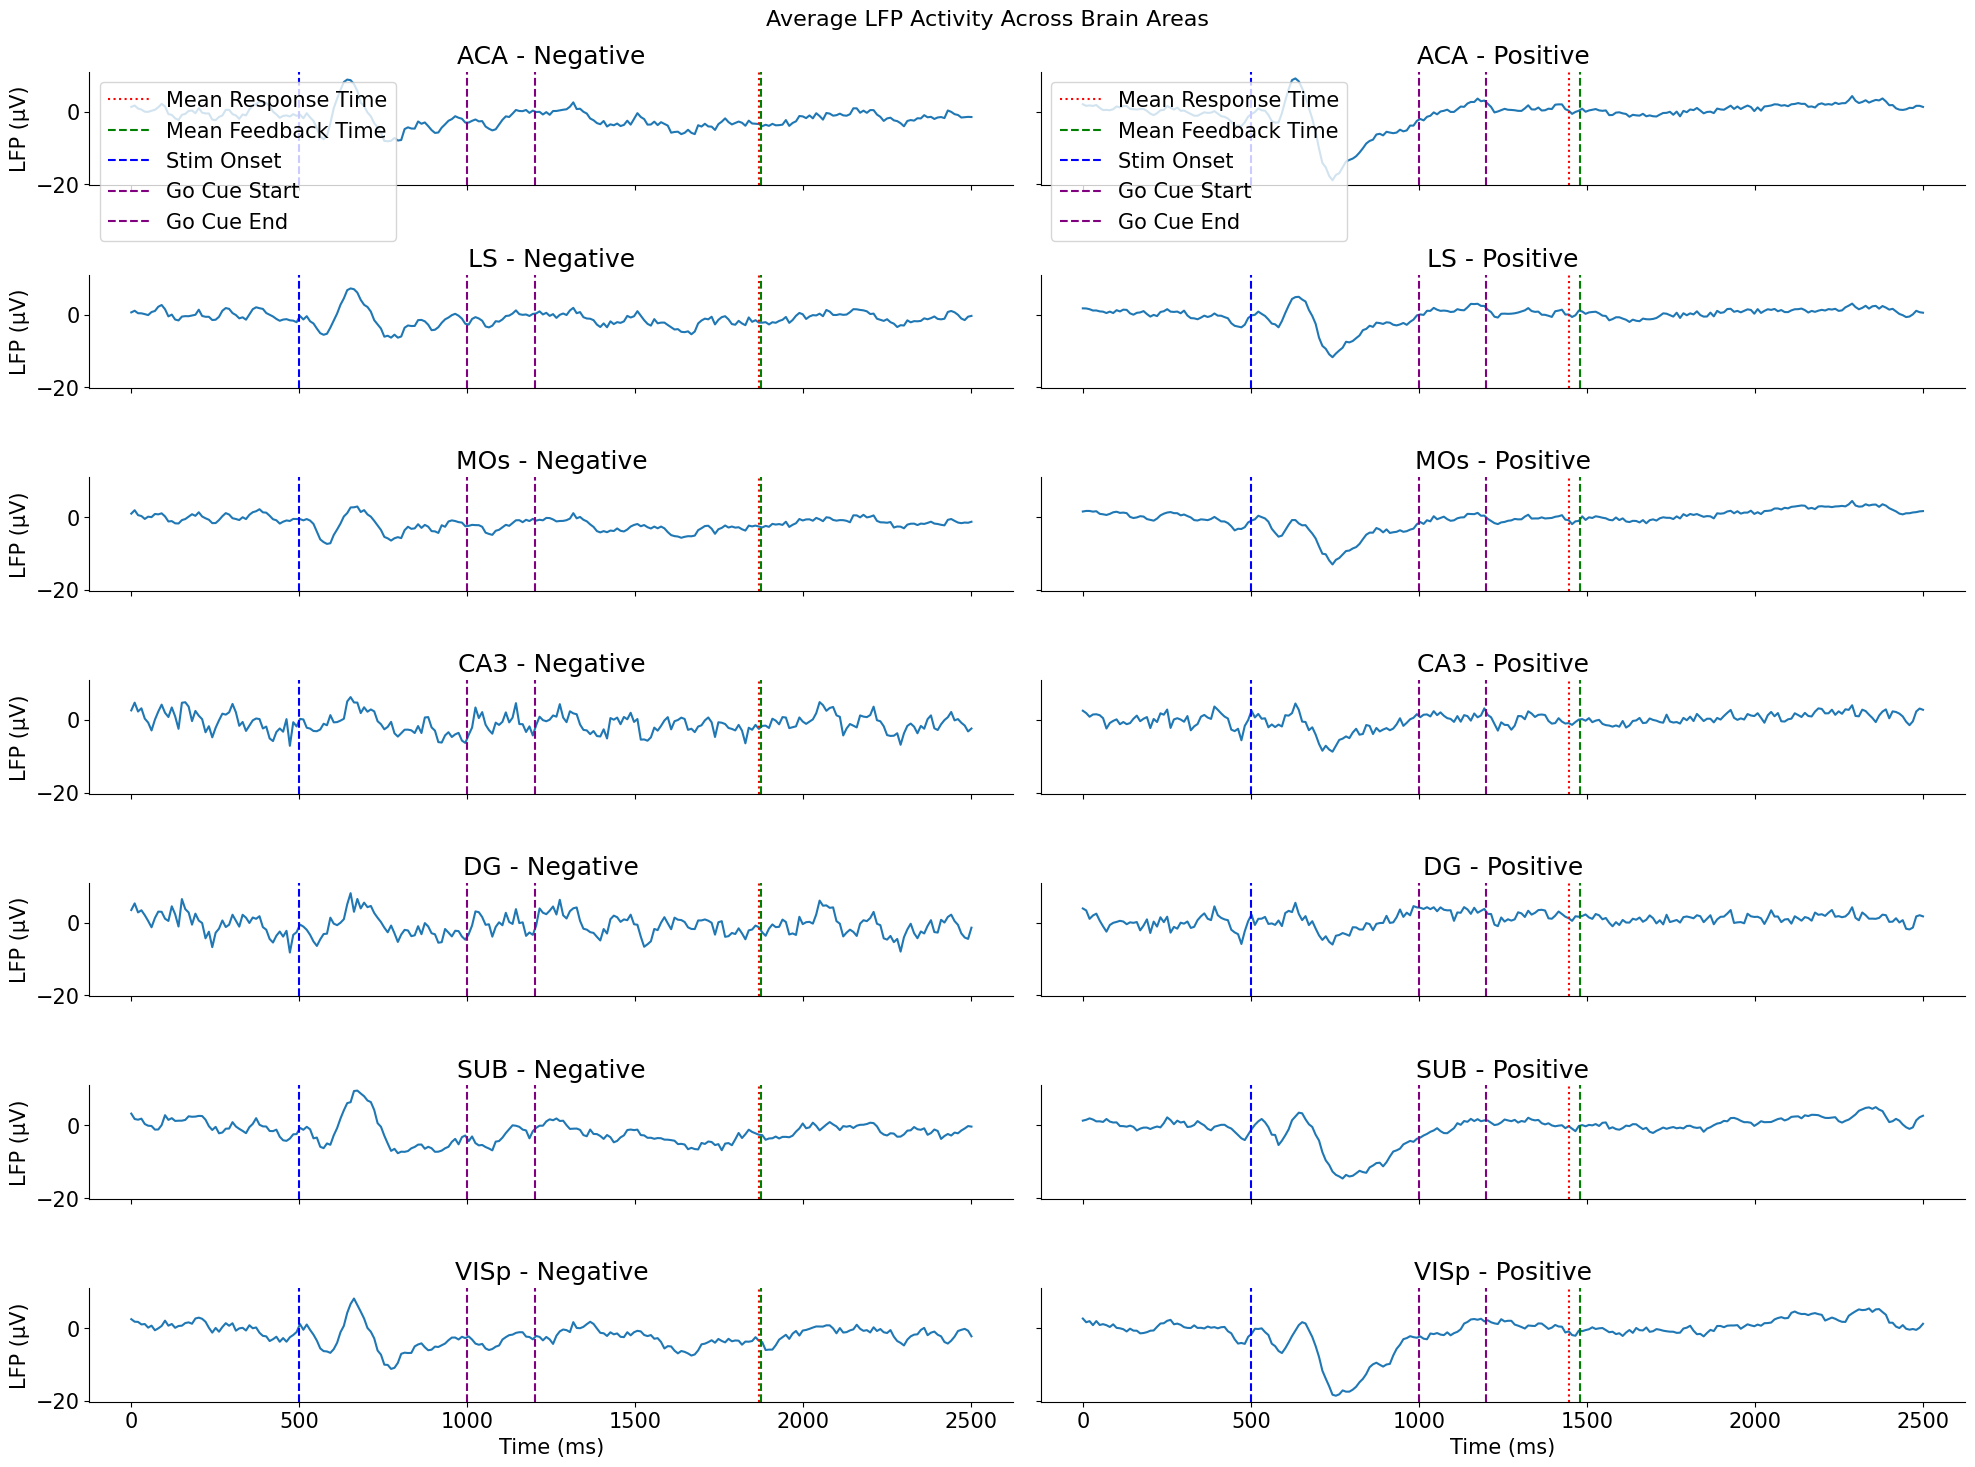

In [ ]:
#Sesssion_1
lfp_data = cori_data[0]['lfp']
feedback = cori_data[0]['feedback_type']
response_times = cori_data[0]['response_time']
feedback_times = cori_data[0]['feedback_time']

# Time vector for plotting
time = np.linspace(0, 2500, 250)  # Assuming 2500 ms total, adjust if your timing differs
brain_areas = cori_data[0]['brain_area_lfp']

def plot_lfp_feedback(ax_col, feedback_value, title_suffix):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # converting from seconds to ms if necessary
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # converting from seconds to ms if necessary

    # Plotting for each brain area
    for i in range(len(ax_col)):
        ax = ax_col[i]
        ax.plot(time, average_lfp[i])
        ax.axvline(mean_response_time, color='red', linestyle=':', label='Mean Response Time')
        ax.axvline(mean_feedback_time, color='green', linestyle='--', label='Mean Feedback Time')
        ax.axvline(500, color='blue', linestyle='--', label='Stim Onset')
        ax.axvline(1000, color='purple', linestyle='--', label='Go Cue Start')
        ax.axvline(1200, color='purple', linestyle='--', label='Go Cue End')
        ax.set_title(f'{brain_areas[i]} - {title_suffix}')
        if i == 0:  # Only add the legend to the first subplot in each column to avoid redundancy
            ax.legend()

# Create a large figure to hold all subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 15), sharex=True, sharey=True)

# Plot negative feedback on the left column of axes
plot_lfp_feedback(axes[:, 0], -1, "Negative")

# Plot positive feedback on the right column of axes
plot_lfp_feedback(axes[:, 1], 1, "Positive")

# Setting common labels and x-axis labels for bottom plots
for ax in axes[:, 0]:  # Only set ylabel for the left column
    ax.set_ylabel('LFP (µV)')
for ax in axes[-1, :]:  # Only set xlabel for the bottom row
    ax.set_xlabel('Time (ms)')

plt.tight_layout()
plt.suptitle('Average LFP Activity Across Brain Areas', fontsize=16)
plt.show()


In [ ]:
#@title ##Session 1 with plotly

# Assuming data retrieval is set up correctly
lfp_data = cori_data[0]['lfp']
feedback = cori_data[0]['feedback_type']
response_times = cori_data[0]['response_time']
feedback_times = cori_data[0]['feedback_time']
brain_areas = cori_data[0]['brain_area_lfp']
time = np.linspace(0, 2500, 250)  # Ensure time is correctly set

def create_plot(feedback_value, title):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # Convert to ms
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # Convert to ms

    fig = go.Figure()

    # Check the number of areas processed
    print(f"Number of brain areas in data: {len(average_lfp)}")
    print(f"Brain areas listed: {brain_areas}")

    for i, area in enumerate(brain_areas):
        if i >= len(average_lfp):
            print(f"Skipping area {area} due to insufficient data.")
            continue

        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[i],
            mode='lines',
            name=area
        ))

    # Adding mean time vertical lines
    fig.add_vline(x=mean_response_time, line_width=2, line_dash="dash", line_color="red")
    fig.add_vline(x=mean_feedback_time, line_width=2, line_dash="dot", line_color="green")
    fig.add_vline(x=500, line_width=2, line_dash="dash", line_color="blue", name="Stim Onset")
    fig.add_vline(x=1000, line_width=2, line_dash="dash", line_color="purple", name="Go Cue Start")
    fig.add_vline(x=1200, line_width=2, line_dash="dash", line_color="purple", name="Go Cue End")

    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity Across Brain Areas Session 1",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=800
    )
    return fig

# Create and display separate plots for negative and positive feedback
fig_negative = create_plot(-1, "Negative")
fig_positive = create_plot(1, "Positive")

fig_negative.write_html('negative_feedback.html')
fig_positive.write_html('positive_feedback.html')

fig_negative.show()
fig_positive.show()


Number of brain areas in data: 7
Brain areas listed: ['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']
Number of brain areas in data: 7
Brain areas listed: ['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']


In [ ]:
#@title ##Session 1 with Plotly upsampling to check neg sessions irratic activity


# Assuming data retrieval is set up correctly
lfp_data = cori_data[0]['lfp']
feedback = cori_data[0]['feedback_type']
response_times = cori_data[0]['response_time']
feedback_times = cori_data[0]['feedback_time']
brain_areas = cori_data[0]['brain_area_lfp']
time = np.linspace(0, 2500, 250)  # Ensure time is correctly set

# Upsampling negative feedbacks
negative_indices = np.where(feedback == -1)[0]
positive_indices = np.where(feedback == 1)[0]
upsampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=True)
balanced_indices = np.concatenate([upsampled_negative_indices, positive_indices])

# Filter data based on balanced indices
lfp_balanced = lfp_data[:, balanced_indices, :]
feedback_balanced = feedback[balanced_indices]
response_times_balanced = response_times[balanced_indices]
feedback_times_balanced = feedback_times[balanced_indices]

def create_plot(feedback_value, title):
    feedback_indices = np.where(feedback_balanced == feedback_value)[0]
    lfp_filtered = lfp_balanced[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times_balanced[feedback_indices]) * 1000  # Convert to ms
    mean_feedback_time = np.mean(feedback_times_balanced[feedback_indices]) * 1000  # Convert to ms

    fig = go.Figure()

    # Check the number of areas processed
    print(f"Number of brain areas in data: {len(average_lfp)}")
    print(f"Brain areas listed: {brain_areas}")

    for i, area in enumerate(brain_areas):
        if i >= len(average_lfp):
            print(f"Skipping area {area} due to insufficient data.")
            continue

        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[i],
            mode='lines',
            name=area
        ))

    # Adding mean time vertical lines
    fig.add_vline(x=mean_response_time, line_width=2, line_dash="dash", line_color="red")
    fig.add_vline(x=mean_feedback_time, line_width=2, line_dash="dot", line_color="green")
    fig.add_vline(x=500, line_width=2, line_dash="dash", line_color="blue", name="Stim Onset")
    fig.add_vline(x=1000, line_width=2, line_dash="dash", line_color="purple", name="Go Cue Start")
    fig.add_vline(x=1200, line_width=2, line_dash="dash", line_color="purple", name="Go Cue End")

    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity Across Brain Areas Session 1 (Neg Upsampled Positive same)",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=800
    )
    return fig

# Create and display separate plots for negative and positive feedback
fig_negative = create_plot(-1, "Negative")
fig_positive = create_plot(1, "Positive")

fig_negative.write_html('negative_feedback.html')
fig_positive.write_html('positive_feedback.html')

fig_negative.show()
fig_positive.show()

Number of brain areas in data: 7
Brain areas listed: ['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']
Number of brain areas in data: 7
Brain areas listed: ['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']


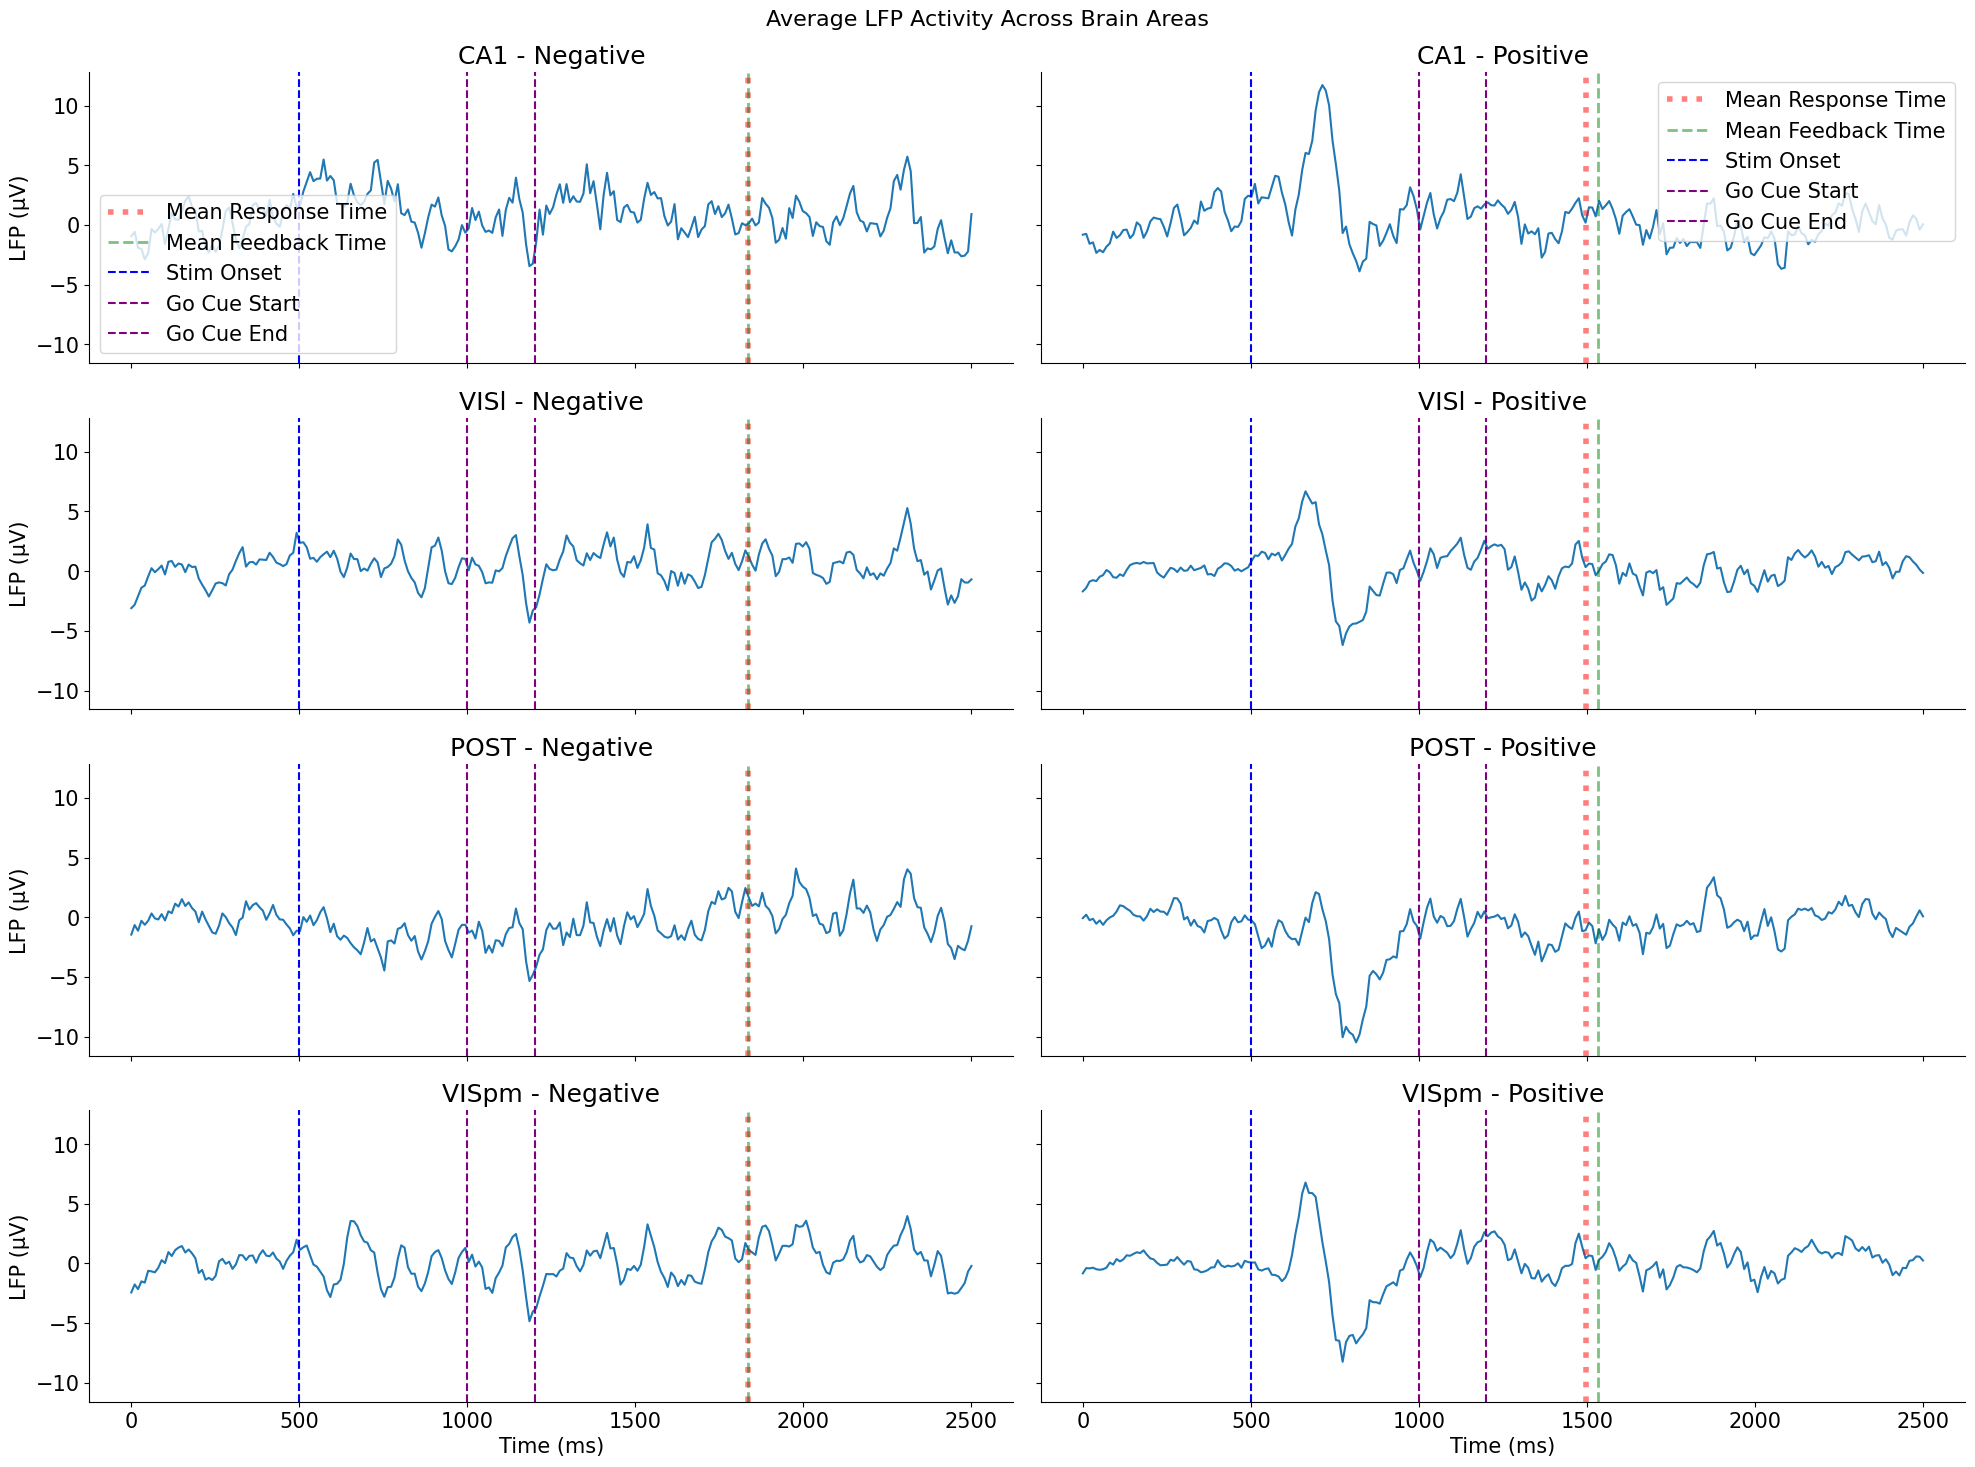

In [ ]:
#@title Session 2 plots
#Sesssion_2
lfp_data = cori_data[1]['lfp']
feedback = cori_data[1]['feedback_type']
response_times = cori_data[1]['response_time']
feedback_times = cori_data[1]['feedback_time']

# Time vector for plotting
time = np.linspace(0, 2500, 250)  # Assuming 2500 ms total, adjust if your timing differs
brain_areas = cori_data[1]['brain_area_lfp']


def plot_lfp_feedback(ax_col, feedback_value, title_suffix):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # converting from seconds to ms if necessary
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # converting from seconds to ms if necessary

    # Plotting for each brain area
    for i in range(len(ax_col)):
        ax = ax_col[i]
        ax.plot(time, average_lfp[i])
        ax.axvline(mean_response_time, color='red', linestyle=':',alpha=0.5,linewidth=4, label='Mean Response Time')
        ax.axvline(mean_feedback_time, color='green', linestyle='--',alpha=0.5,linewidth=2, label='Mean Feedback Time')
        ax.axvline(500, color='blue', linestyle='--', label='Stim Onset')
        ax.axvline(1000, color='purple', linestyle='--', label='Go Cue Start')
        ax.axvline(1200, color='purple', linestyle='--', label='Go Cue End')

        # Annotations for clarity
        #ax.text(mean_response_time, 1.1, 'Resp', color='red', horizontalalignment='right')
        #ax.text(mean_feedback_time + 5, 1.1, 'Feedb', color='green', horizontalalignment='left')

        ax.set_title(f'{brain_areas[i]} - {title_suffix}')
        if i == 0:  # Only add the legend to the first subplot in each column to avoid redundancy
            ax.legend()



# Create a large figure to hold all subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15), sharex=True, sharey=True)

# Plot negative feedback on the left column of axes
plot_lfp_feedback(axes[:, 0], -1, "Negative")

# Plot positive feedback on the right column of axes
plot_lfp_feedback(axes[:, 1], 1, "Positive")

# Setting common labels and x-axis labels for bottom plots
for ax in axes[:, 0]:  # Only set ylabel for the left column
    ax.set_ylabel('LFP (µV)')
for ax in axes[-1, :]:  # Only set xlabel for the bottom row
    ax.set_xlabel('Time (ms)')

plt.tight_layout()
plt.suptitle('Average LFP Activity Across Brain Areas', fontsize=16)
plt.show()

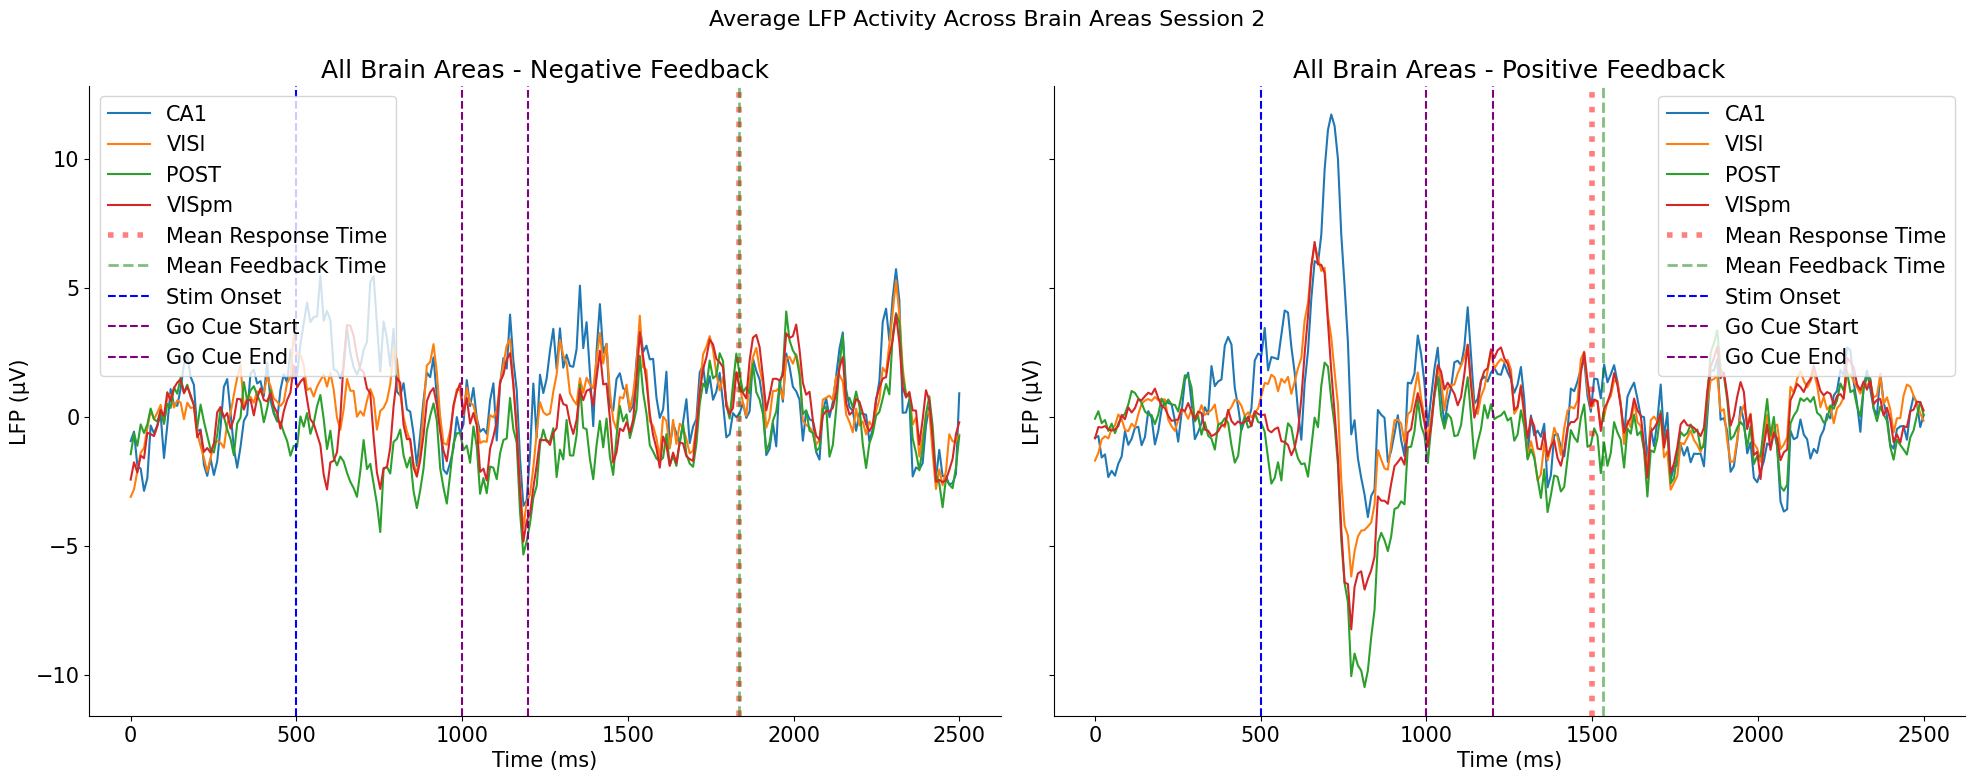

In [ ]:
#@title ### Session 2 combined matlplotlib

#  data setup
lfp_data = cori_data[1]['lfp']
feedback = cori_data[1]['feedback_type']
response_times = cori_data[1]['response_time']
feedback_times = cori_data[1]['feedback_time']
brain_areas = cori_data[1]['brain_area_lfp']
time = np.linspace(0, 2500, 250)  # Assuming 2500 ms total, adjust if your timing differs

def plot_lfp_feedback(ax, feedback_value, title_suffix):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # ms
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # ms

    for i, area in enumerate(brain_areas):
        ax.plot(time, average_lfp[i], label=f'{area}')

    ax.axvline(mean_response_time, color='red', linestyle=':', alpha=0.5, linewidth=4, label='Mean Response Time')
    ax.axvline(mean_feedback_time, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Mean Feedback Time')
    ax.axvline(500, color='blue', linestyle='--', label='Stim Onset')
    ax.axvline(1000, color='purple', linestyle='--', label='Go Cue Start')
    ax.axvline(1200, color='purple', linestyle='--', label='Go Cue End')

    ax.set_title(f'All Brain Areas - {title_suffix}')
    ax.legend()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)

plot_lfp_feedback(axes[0], -1, "Negative Feedback")
plot_lfp_feedback(axes[1], 1, "Positive Feedback")

for ax in axes:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('LFP (µV)')

plt.suptitle('Average LFP Activity Across Brain Areas Session 2', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#@title ##Session 2 with plotly

# Assuming data retrieval is set up correctly
lfp_data = cori_data[1]['lfp']
feedback = cori_data[1]['feedback_type']
response_times = cori_data[1]['response_time']
feedback_times = cori_data[1]['feedback_time']
brain_areas = cori_data[1]['brain_area_lfp']
time = np.linspace(0, 2500, 250)  # Ensure time is correctly set

def create_plot(feedback_value, title):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # Convert to ms
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # Convert to ms

    fig = go.Figure()

    # Check the number of areas processed
    print(f"Number of brain areas in data: {len(average_lfp)}")
    print(f"Brain areas listed: {brain_areas}")

    for i, area in enumerate(brain_areas):
        if i >= len(average_lfp):
            print(f"Skipping area {area} due to insufficient data.")
            continue

        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[i],
            mode='lines',
            name=area
        ))

    # Adding mean time vertical lines
    fig.add_vline(x=mean_response_time, line_width=2, line_dash="dash", line_color="red")
    fig.add_vline(x=mean_feedback_time, line_width=2, line_dash="dot", line_color="green")
    fig.add_vline(x=500, line_width=2, line_dash="dash", line_color="blue", name="Stim Onset")
    fig.add_vline(x=1000, line_width=2, line_dash="dash", line_color="purple", name="Go Cue Start")
    fig.add_vline(x=1200, line_width=2, line_dash="dash", line_color="purple", name="Go Cue End")

    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity Across Brain Areas",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=1300
    )
    return fig

# Create and display separate plots for negative and positive feedback
fig_negative = create_plot(-1, "Negative")
fig_positive = create_plot(1, "Positive")

fig_negative.write_html('negative_feedback.html')
fig_positive.write_html('positive_feedback.html')

fig_negative.show()
fig_positive.show()


Number of brain areas in data: 4
Brain areas listed: ['CA1', 'VISl', 'POST', 'VISpm']
Number of brain areas in data: 4
Brain areas listed: ['CA1', 'VISl', 'POST', 'VISpm']


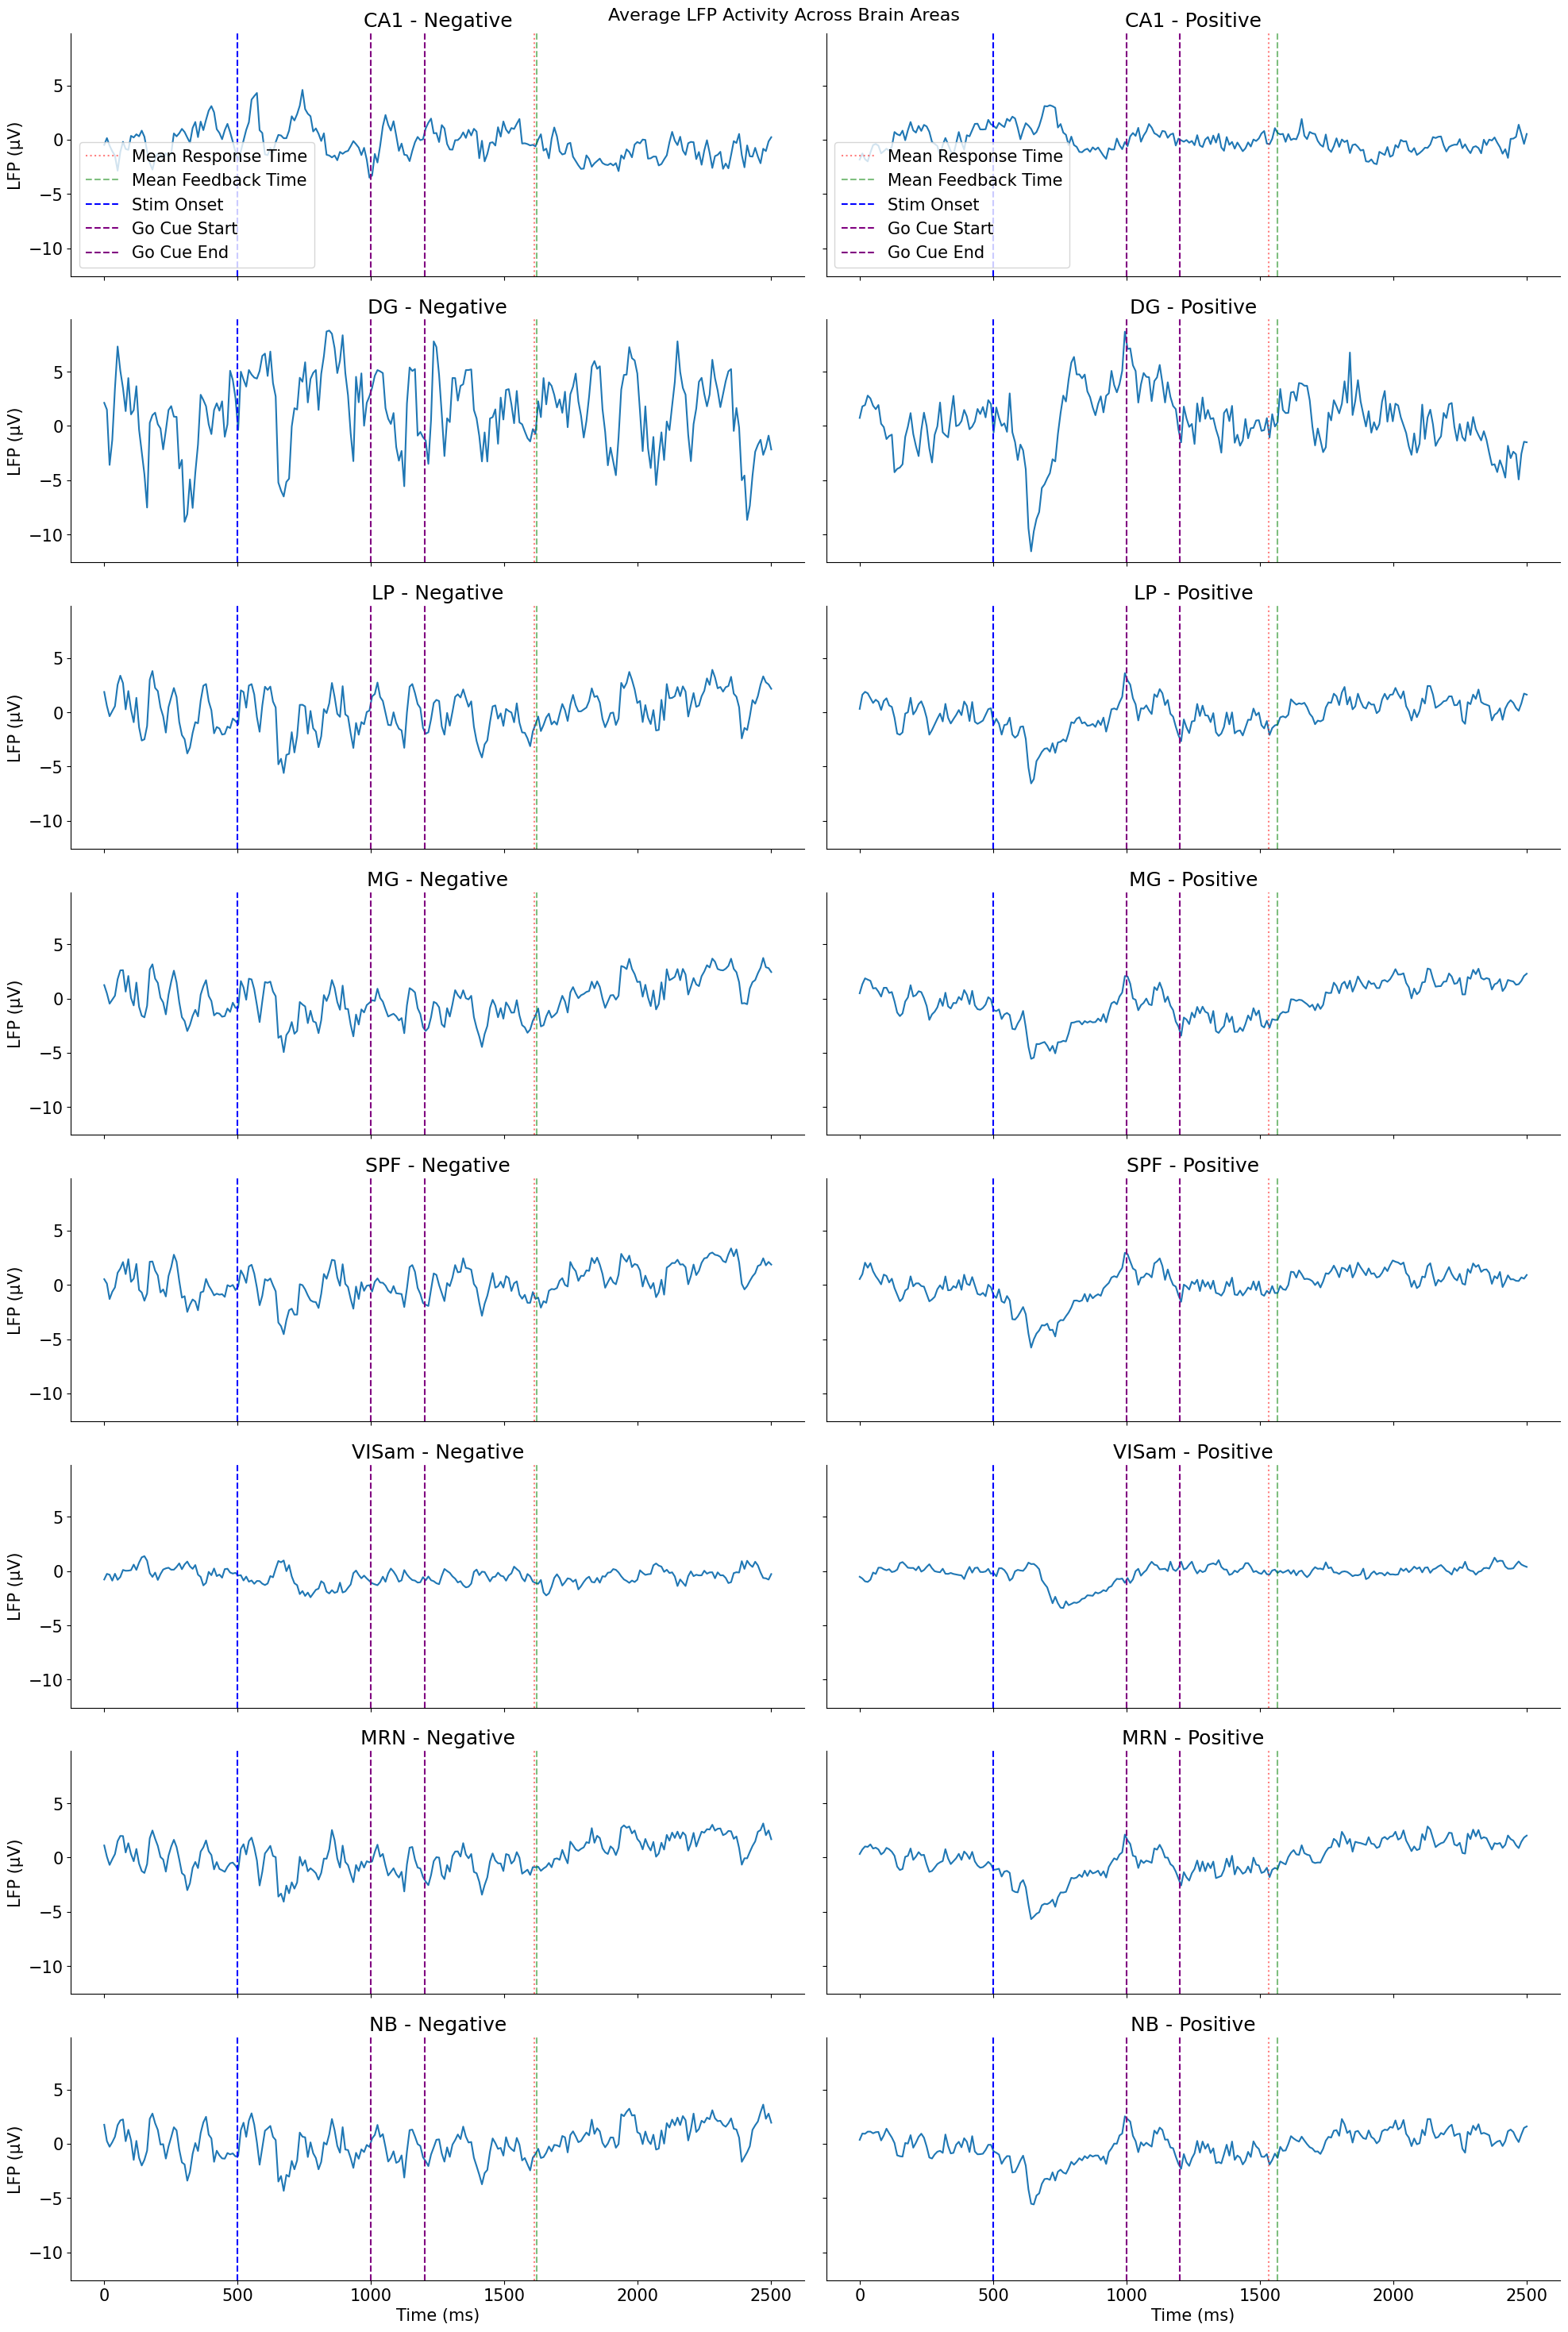

In [ ]:
#@title     Session3
#Sesssion_3
lfp_data = cori_data[2]['lfp']
feedback = cori_data[2]['feedback_type']
response_times = cori_data[2]['response_time']
feedback_times = cori_data[2]['feedback_time']

# Time vector for plotting
time = np.linspace(0, 2500, 250)  # Assuming 2500 ms total, adjust if your timing differs
brain_areas = cori_data[2]['brain_area_lfp']

def plot_lfp_feedback(ax_col, feedback_value, title_suffix):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # converting from seconds to ms if necessary
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # converting from seconds to ms if necessary

    # Plotting for each brain area
    for i in range(len(ax_col)):
        ax = ax_col[i]
        ax.plot(time, average_lfp[i])
        ax.axvline(mean_response_time, color='red', linestyle=':',alpha=0.5, label='Mean Response Time')
        ax.axvline(mean_feedback_time, color='green', linestyle='--',alpha=0.5, label='Mean Feedback Time')
        ax.axvline(500, color='blue', linestyle='--', label='Stim Onset')
        ax.axvline(1000, color='purple', linestyle='--', label='Go Cue Start')
        ax.axvline(1200, color='purple', linestyle='--', label='Go Cue End')

        ax.set_title(f'{brain_areas[i]} - {title_suffix}')
        if i == 0:  # Only add the legend to the first subplot in each column to avoid redundancy
            ax.legend()

# Create a large figure to hold all subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 30), sharex=True, sharey=True)

# Plot negative feedback on the left column of axes
plot_lfp_feedback(axes[:, 0], -1, "Negative")

# Plot positive feedback on the right column of axes
plot_lfp_feedback(axes[:, 1], 1, "Positive")

# Setting common labels and x-axis labels for bottom plots
for ax in axes[:, 0]:  # Only set ylabel for the left column
    ax.set_ylabel('LFP (µV)')
for ax in axes[-1, :]:  # Only set xlabel for the bottom row
    ax.set_xlabel('Time (ms)')

plt.tight_layout()
plt.suptitle('Average LFP Activity Across Brain Areas', fontsize=16)
plt.show()

In [ ]:
#@title ##Session 3 with plotly

# Assuming data retrieval is set up correctly
lfp_data = cori_data[2]['lfp']
feedback = cori_data[2]['feedback_type']
response_times = cori_data[2]['response_time']
feedback_times = cori_data[2]['feedback_time']
brain_areas = cori_data[2]['brain_area_lfp']
time = np.linspace(0, 2500, 250)  # Ensure time is correctly set

def create_plot(feedback_value, title):
    feedback_indices = np.where(feedback == feedback_value)[0]
    lfp_filtered = lfp_data[:, feedback_indices, :]
    average_lfp = np.mean(lfp_filtered, axis=1)
    mean_response_time = np.mean(response_times[feedback_indices]) * 1000  # Convert to ms
    mean_feedback_time = np.mean(feedback_times[feedback_indices]) * 1000   # Convert to ms

    fig = go.Figure()

    # Check the number of areas processed
    print(f"Number of brain areas in data: {len(average_lfp)}")
    print(f"Brain areas listed: {brain_areas}")

    for i, area in enumerate(brain_areas):
        if i >= len(average_lfp):
            print(f"Skipping area {area} due to insufficient data.")
            continue

        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[i],
            mode='lines',
            name=area
        ))

    # Adding mean time vertical lines
    fig.add_vline(x=mean_response_time, line_width=2, line_dash="dash", line_color="red")
    fig.add_vline(x=mean_feedback_time, line_width=2, line_dash="dot", line_color="green")
    fig.add_vline(x=500, line_width=2, line_dash="dash", line_color="blue", name="Stim Onset")
    fig.add_vline(x=1000, line_width=2, line_dash="dash", line_color="purple", name="Go Cue Start")
    fig.add_vline(x=1200, line_width=2, line_dash="dash", line_color="purple", name="Go Cue End")

    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity Across Brain Areas Session 3",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=800
    )
    return fig

# Create and display separate plots for negative and positive feedback
fig_negative = create_plot(-1, "Negative")
fig_positive = create_plot(1, "Positive")

fig_negative.write_html('negative_feedback.html')
fig_positive.write_html('positive_feedback.html')

fig_negative.show()
fig_positive.show()


Number of brain areas in data: 10
Brain areas listed: ['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']
Number of brain areas in data: 10
Brain areas listed: ['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']


In [ ]:
#@title ##All Session  with plotly

# Data retrieval should be correctly set for each session
sessions = [cori_data[0], cori_data[1], cori_data[2]]
time = np.linspace(0, 2500, 250)


def create_plot(feedback_value, title):
    # Setup for data accumulation across sessions
    lfp_accumulator = {}
    response_times_accumulator = []
    feedback_times_accumulator = []

    # Loop through each session and collect data
    for session in [cori_data[0], cori_data[1], cori_data[2]]:
        feedback = session['feedback_type']
        response_times = session['response_time']
        feedback_times = session['feedback_time']
        brain_areas = session['brain_area_lfp']
        lfp_data = session['lfp']

        feedback_indices = np.where(feedback == feedback_value)[0]
        if len(feedback_indices) == 0:
            continue

        lfp_filtered = lfp_data[:, feedback_indices, :]
        response_times_accumulator.extend(response_times[feedback_indices])
        feedback_times_accumulator.extend(feedback_times[feedback_indices])

        for i, area in enumerate(brain_areas):
            if area not in lfp_accumulator:
                lfp_accumulator[area] = []
            lfp_accumulator[area].append(lfp_filtered[i])

    # Compute average LFP and times
    average_lfp = {area: np.mean(np.concatenate(lfp_accumulator[area]), axis=0) for area in lfp_accumulator}
    mean_response_time = np.mean(response_times_accumulator) * 1000
    mean_feedback_time = np.mean(feedback_times_accumulator) * 1000

    # Create figure and add traces
    fig = go.Figure()
    for area in average_lfp:
        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[area],
            mode='lines',
            name=area
        ))

    # Adding event vertical lines
    fig.add_vline(x=mean_response_time, line_width=2, line_dash="dash", line_color="red", name="Mean Response Time")
    fig.add_vline(x=mean_feedback_time, line_width=2, line_dash="dot", line_color="green", name="Mean Feedback Time")
    fig.add_vline(x=500, line_width=2, line_dash="dash", line_color="blue", name="Stim Onset")
    fig.add_vline(x=1000, line_width=2, line_dash="dash", line_color="purple", name="Go Cue Start")
    fig.add_vline(x=1200, line_width=2, line_dash="dash", line_color="purple", name="Go Cue End")

    # Update plot layout
    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity Across Brain Areas Across Sessions",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=800
    )
    return fig

# Generate and display plots for negative and positive feedback
fig_negative = create_plot(-1, "Negative")
fig_positive = create_plot(1, "Positive")

fig_negative.show()
fig_positive.show()


## overlaps

In [ ]:
# Assuming cori_data contains sessions data
sessions = [cori_data[0], cori_data[1], cori_data[2]]
time = np.linspace(0, 2500, 250)  # Assuming the same number of time points in all sessions for simplicity

def find_common_areas(sessions):
    """Identify common brain areas across any two sessions."""
    common_areas = {}
    for i, session_i in enumerate(sessions):
        for j, session_j in enumerate(sessions):
            if i >= j:
                continue
            common = set(session_i['brain_area_lfp']).intersection(session_j['brain_area_lfp'])
            if common:
                common_areas[f"S{i+1}_S{j+1}"] = common
    return common_areas

def create_plot(feedback_value, title, common_areas, session_key):
    lfp_accumulator = {area: [] for area in common_areas}
    response_times_accumulator = []
    feedback_times_accumulator = []

    session_indices = session_key.split('_')
    session_indices = [int(s[1:]) for s in session_indices]  # Extract numerical parts from 'S1', 'S3', etc.
    for session_index in session_indices:
        session = sessions[session_index - 1]
        feedback = session['feedback_type']
        response_times = session['response_time']
        feedback_times = session['feedback_time']
        brain_areas = session['brain_area_lfp']
        lfp_data = session['lfp']

        feedback_indices = np.where(feedback == feedback_value)[0]
        if len(feedback_indices) == 0:
            continue

        lfp_filtered = lfp_data[:, feedback_indices, :]
        response_times_accumulator.extend(response_times[feedback_indices])
        feedback_times_accumulator.extend(feedback_times[feedback_indices])

        for i, area in enumerate(brain_areas):
            if area in common_areas:
                lfp_accumulator[area].append(lfp_filtered[i])

    average_lfp = {area: np.mean(np.concatenate(lfp_accumulator[area]), axis=0) for area in lfp_accumulator}
    mean_response_time = np.mean(response_times_accumulator) * 1000
    mean_feedback_time = np.mean(feedback_times_accumulator) * 1000

    fig = go.Figure()
    for area in average_lfp:
        fig.add_trace(go.Scatter(
            x=time,
            y=average_lfp[area],
            mode='lines',
            name=area
        ))

    # Adding vertical lines to the legend
    fig.add_trace(go.Scatter(
        x=[mean_response_time, mean_response_time],
        y=[np.min(list(average_lfp.values())), np.max(list(average_lfp.values()))],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name='Mean Response Time'
    ))
    fig.add_trace(go.Scatter(
        x=[mean_feedback_time, mean_feedback_time],
        y=[np.min(list(average_lfp.values())), np.max(list(average_lfp.values()))],
        mode='lines',
        line=dict(color='green', dash='dot'),
        name='Mean Feedback Time'
    ))
    fig.add_trace(go.Scatter(
        x=[500, 500],
        y=[np.min(list(average_lfp.values())), np.max(list(average_lfp.values()))],
        mode='lines',
        line=dict(color='blue', dash='dash'),
        name='Stim Onset'
    ))
    fig.add_trace(go.Scatter(
        x=[1000, 1000],
        y=[np.min(list(average_lfp.values())), np.max(list(average_lfp.values()))],
        mode='lines',
        line=dict(color='purple', dash='dash'),
        name='Go Cue Start'
    ))
    fig.add_trace(go.Scatter(
        x=[1200, 1200],
        y=[np.min(list(average_lfp.values())), np.max(list(average_lfp.values()))],
        mode='lines',
        line=dict(color='purple', dash='dash'),
        name='Go Cue End'
    ))

    fig.update_layout(
        title=f"{title} Feedback - Average LFP Activity ({session_key})",
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Brain Areas",
        height=600, width=1200
    )
    return fig

# Identify common areas between any two sessions
common_areas = find_common_areas(sessions)
print(f"Common areas: {common_areas}")

# Generate and display plots for negative and positive feedback for each pair of sessions
for key, areas in common_areas.items():
    fig_negative = create_plot(-1, "Negative", areas, key)
    fig_positive = create_plot(1, "Positive", areas, key)
    fig_negative.show()
    fig_positive.show()


Common areas: {'S1_S3': {'VISp', 'DG'}, 'S2_S3': {'POST', 'CA1'}}


## Overlapping with matplotlib (not correct yet)

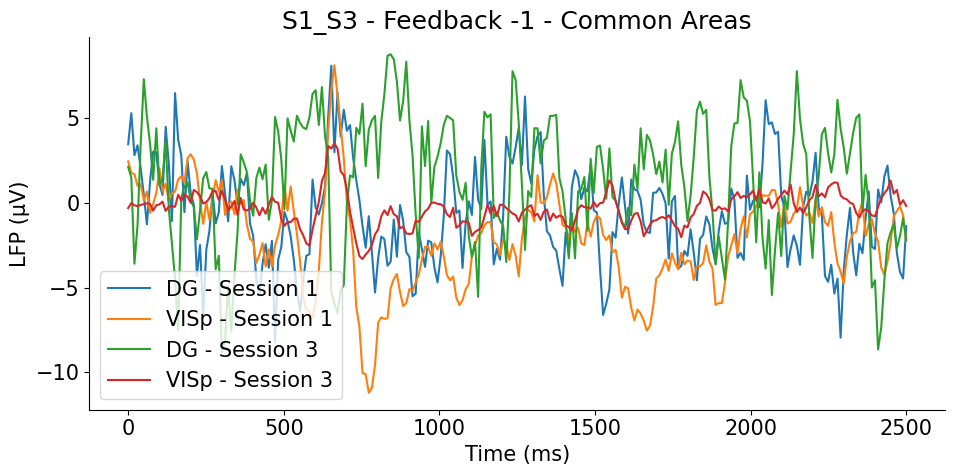

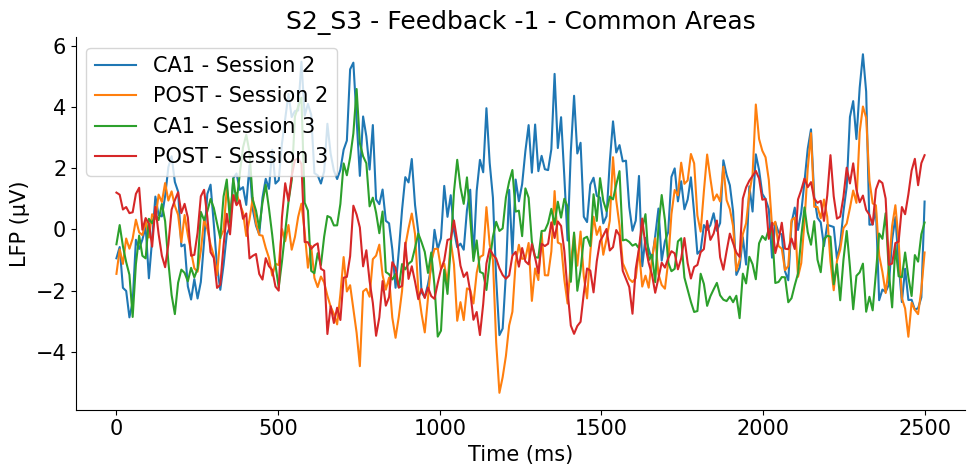

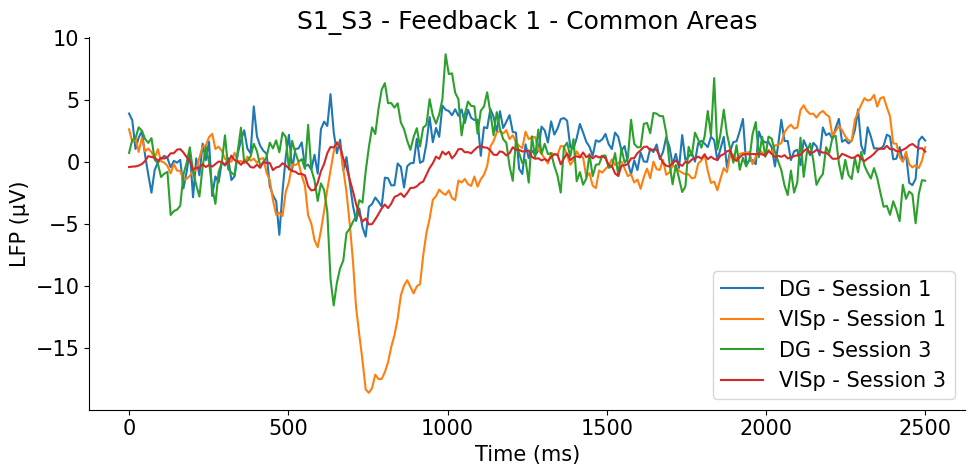

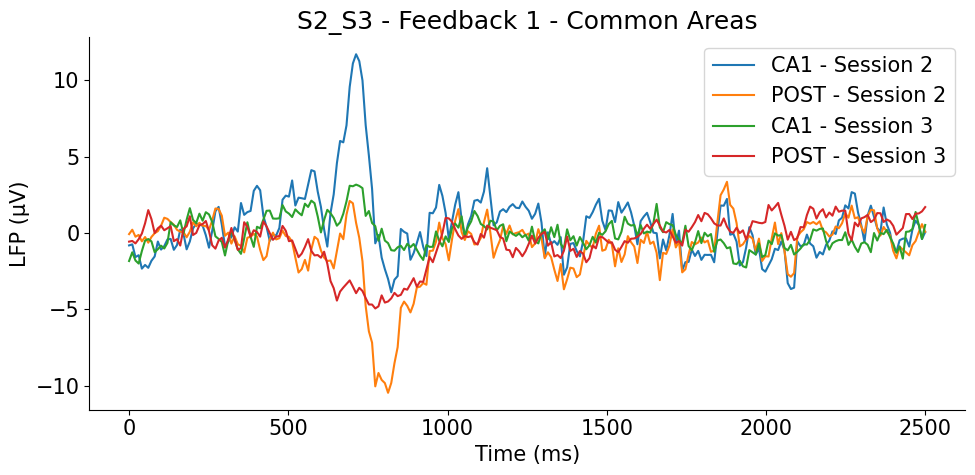

In [ ]:

# Assuming sessions data
sessions = [cori_data[0], cori_data[1], cori_data[2]]
time = np.linspace(0, 2500, 250)  # Assuming the same number of time points in all sessions for simplicity

def find_common_areas(sessions):
    """Identify common brain areas across any two sessions."""
    common_areas = {}
    for i, session_i in enumerate(sessions):
        for j, session_j in enumerate(sessions):
            if i >= j:
                continue
            common = set(session_i['brain_area_lfp']).intersection(session_j['brain_area_lfp'])
            if common:
                common_areas[f"S{i+1}_S{j+1}"] = common
    return common_areas

def plot_common_areas(feedback_value, common_areas):
    """Plot each set of common areas for given feedback value in separate figures."""
    for key, areas in common_areas.items():
        fig, ax = plt.subplots(figsize=(10, 5))
        for session_index, session in enumerate(sessions):
            feedback = session['feedback_type']
            brain_areas = session['brain_area_lfp']
            lfp_data = session['lfp']

            feedback_indices = np.where(feedback == feedback_value)[0]
            if len(feedback_indices) == 0:
                continue  # Skip if no matching feedback

            for i, area in enumerate(brain_areas):
                if area in areas:
                    lfp_filtered = lfp_data[i, feedback_indices, :]
                    average_lfp = np.mean(lfp_filtered, axis=0)
                    ax.plot(time, average_lfp, label=f'{area} - Session {session_index + 1}')

        ax.set_title(f"{key} - Feedback {feedback_value} - Common Areas")
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('LFP (µV)')
        ax.legend()
        plt.show()

# Identify common areas between any two sessions
common_areas = find_common_areas(sessions)

# Plot common areas for negative and positive feedback
plot_common_areas(-1, common_areas)
plot_common_areas(1, common_areas)

___

In [ ]:
#@title ignore, power spectra, no sampling rate, need more knowledge

def plot_power_spectra(lfp_data, sampling_rate):
    """
    Plots the power spectral density for LFP data.

    Parameters:
    - lfp_data: ndarray, LFP data from which to compute power spectra.
    - sampling_rate: float, the sampling rate of the data in Hz.
    """
    # Number of data points
    n = len(lfp_data)
    # Compute the fft
    fft_output = np.fft.fft(lfp_data)
    # Compute the power spectrum
    power_spectrum = np.abs(fft_output) ** 2
    # Create a frequency array
    freq = np.fft.fftfreq(n, d=1/sampling_rate)

    # Only plot the positive frequencies
    pos_mask = freq >= 0
    freqs = freq[pos_mask]
    powers = power_spectrum[pos_mask]

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, powers)
    plt.title('Power Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim(0, sampling_rate / 2)  # Only up to Nyquist frequency
    plt.ylim(0, np.max(powers)*1.1)  # Limit y-axis for better visibility
    plt.show()

# Example usage
sampling_rate = 1000  # Example sampling rate in Hz
lfp_example = np.random.randn(1000)  # Example LFP data, replace with actual data
#plot_power_spectra(lfp_example, sampling_rate)



def plot_power_spectra_unknown_sr(lfp_data):
    """
    Plots the power spectral density for LFP data without knowing the sampling rate.
    Frequency axis will be in arbitrary units.

    Parameters:
    - lfp_data: ndarray, LFP data from which to compute power spectra.
    """
    # Number of data points
    n = len(lfp_data)
    # Compute the fft
    fft_output = np.fft.fft(lfp_data)
    # Compute the power spectrum
    power_spectrum = np.abs(fft_output) ** 2
    # Generate an array of arbitrary frequency units
    freq = np.fft.fftfreq(n)

    # Only plot the positive frequencies
    pos_mask = freq >= 0
    freqs = freq[pos_mask]
    powers = power_spectrum[pos_mask]

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, powers)
    plt.title('Power Spectrum (Arbitrary Units)')
    plt.xlabel('Frequency (Arbitrary Units)')
    plt.ylabel('Power')
    plt.legend()
    plt.show()



#plot_power_spectra_unknown_sr(cori_data[0]['lfp'][0])


---

# **Visual Stimuli Contrast vs LFP -- Session 0**

In [ ]:
# data prep
sessions = [cori_data[0], cori_data[1], cori_data[2]]
session = sessions[0]
lfp_data = session['lfp']  # shape: (n_channels, n_trials, n_timepoints)
vis_left_p = session['contrast_left']  # length: n_trials
vis_right_p = session['contrast_right']  # length: n_trials
regions = session['brain_area_lfp']  # length: n_channels
#unique_regions = np.unique(regions)  # unique brain areas
time = np.linspace(0, 2500, 250)  # Assuming 250 time points

right_only_mask = np.logical_and(vis_left_p == 0, vis_right_p > 0)
left_only_mask = np.logical_and(vis_left_p > 0, vis_right_p == 0)
both_mask = np.logical_and(vis_left_p > 0, vis_right_p > 0)


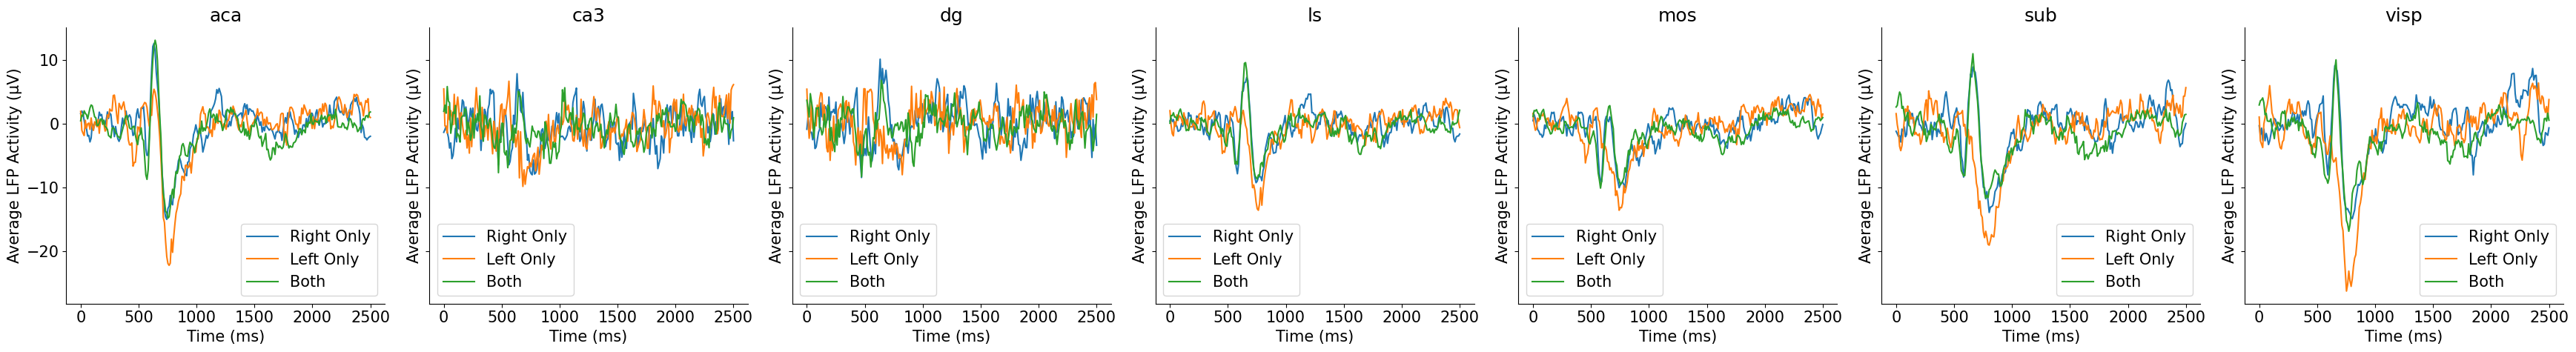

In [ ]:

# Re-define unique_regions
unique_regions = np.unique([r.lower() for r in regions])

fig, axes = plt.subplots(1, len(unique_regions), figsize=(len(unique_regions) * 5, 5), sharey=True)

for j, region in enumerate(unique_regions):
    ax = axes[j]
    ax.set_title(region)

    region_indices = np.where([r.lower() == region for r in regions])[0]

    print(f"Processing region: {region}")
    print(f"Region indices: {region_indices}")

    for mask, label in zip([right_only_mask, left_only_mask, both_mask], ['Right Only', 'Left Only', 'Both']):
        if np.any(mask):
            if region_indices.size > 0:
                avg_lfp = np.mean(lfp_data[region_indices][:, mask, :], axis=1)  # mean across trials
                ax.plot(time, np.mean(avg_lfp, axis=0), label=label)  # Further average across channels if needed
            else:
                print(f"No data available for {label} in region {region}")
        else:
            print(f"No trials match the condition {label} in region {region}")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average LFP Activity (µV)')
    if len(ax.get_legend_handles_labels()[0]) > 0:  # Check if there are any legend entries to add
        ax.legend()

plt.tight_layout()
#save to png
plt.savefig("sides.png",transparent="true")
plt.show()


### Session 2

Processing region: ca1
Region indices: [0]
Processing region: post
Region indices: [2]
Processing region: visl
Region indices: [1]
Processing region: vispm
Region indices: [3]


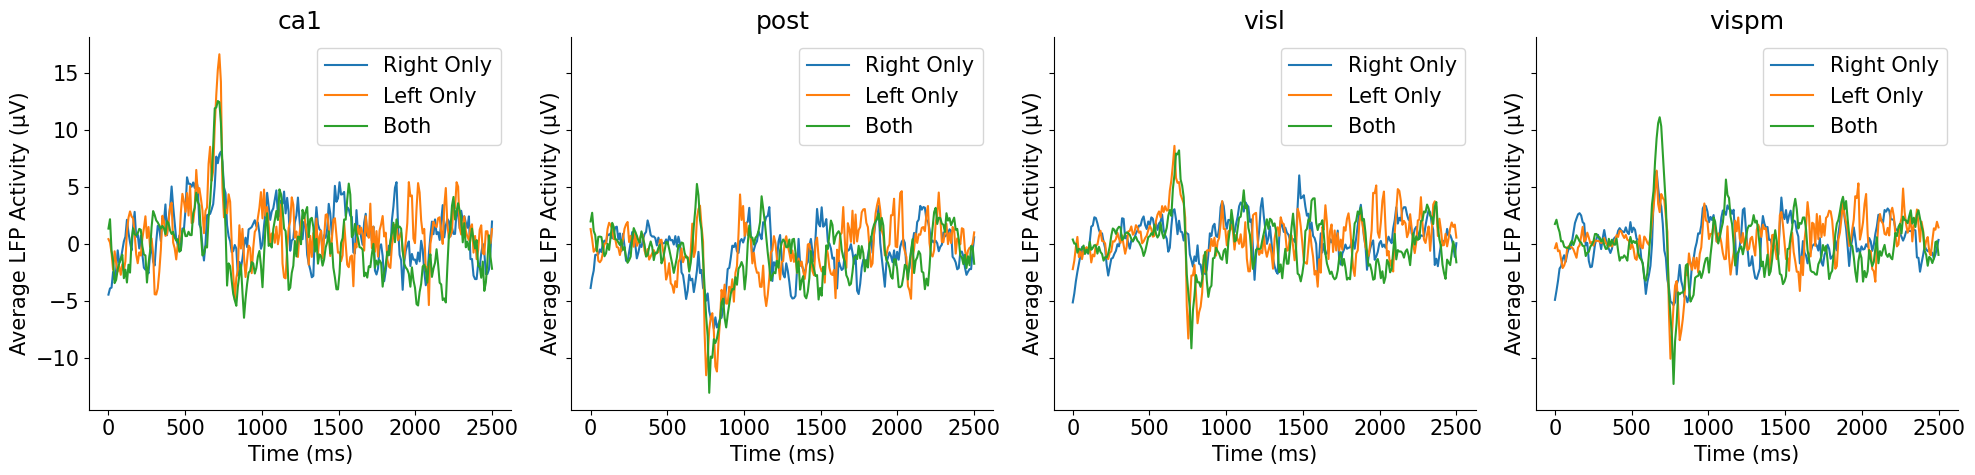

In [ ]:
# data prep s2
sessions = [cori_data[0], cori_data[1], cori_data[2]]
session = sessions[1]
lfp_data = session['lfp']  # shape: (n_channels, n_trials, n_timepoints)
vis_left_p = session['contrast_left']  # length: n_trials
vis_right_p = session['contrast_right']  # length: n_trials
regions = session['brain_area_lfp']  # length: n_channels
#unique_regions = np.unique(regions)  # unique brain areas
time = np.linspace(0, 2500, 250)  # Assuming 250 time points

right_only_mask = np.logical_and(vis_left_p == 0, vis_right_p > 0)
left_only_mask = np.logical_and(vis_left_p > 0, vis_right_p == 0)
both_mask = np.logical_and(vis_left_p > 0, vis_right_p > 0)


# Re-define unique_regions
unique_regions = np.unique([r.lower() for r in regions])

fig, axes = plt.subplots(1, len(unique_regions), figsize=(len(unique_regions) * 5, 5), sharey=True)

for j, region in enumerate(unique_regions):
    ax = axes[j]
    ax.set_title(region)

    region_indices = np.where([r.lower() == region for r in regions])[0]

    print(f"Processing region: {region}")
    print(f"Region indices: {region_indices}")

    for mask, label in zip([right_only_mask, left_only_mask, both_mask], ['Right Only', 'Left Only', 'Both']):
        if np.any(mask):
            if region_indices.size > 0:
                avg_lfp = np.mean(lfp_data[region_indices][:, mask, :], axis=1)  # mean across trials
                ax.plot(time, np.mean(avg_lfp, axis=0), label=label)  # Further average across channels if needed
            else:
                print(f"No data available for {label} in region {region}")
        else:
            print(f"No trials match the condition {label} in region {region}")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average LFP Activity (µV)')
    if len(ax.get_legend_handles_labels()[0]) > 0:  # Check if there are any legend entries to add
        ax.legend()

plt.tight_layout()
#save to png
plt.savefig("sides.png",transparent="true")
plt.show()

### Session 3

In [ ]:
cori_data[0]['brain_area_lfp']

['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']

In [ ]:
cori_data[1]['brain_area_lfp']

['CA1', 'VISl', 'POST', 'VISpm']

In [ ]:
cori_data[2]['brain_area_lfp']

['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']

Processing region: ca1
Region indices: [0]
Processing region: dg
Region indices: [1]
Processing region: lp
Region indices: [2]
Processing region: mg
Region indices: [3]
Processing region: mrn
Region indices: [6]
Processing region: nb
Region indices: [7]
Processing region: post
Region indices: [8]
Processing region: spf
Region indices: [4]
Processing region: visam
Region indices: [5]
Processing region: visp
Region indices: [9]


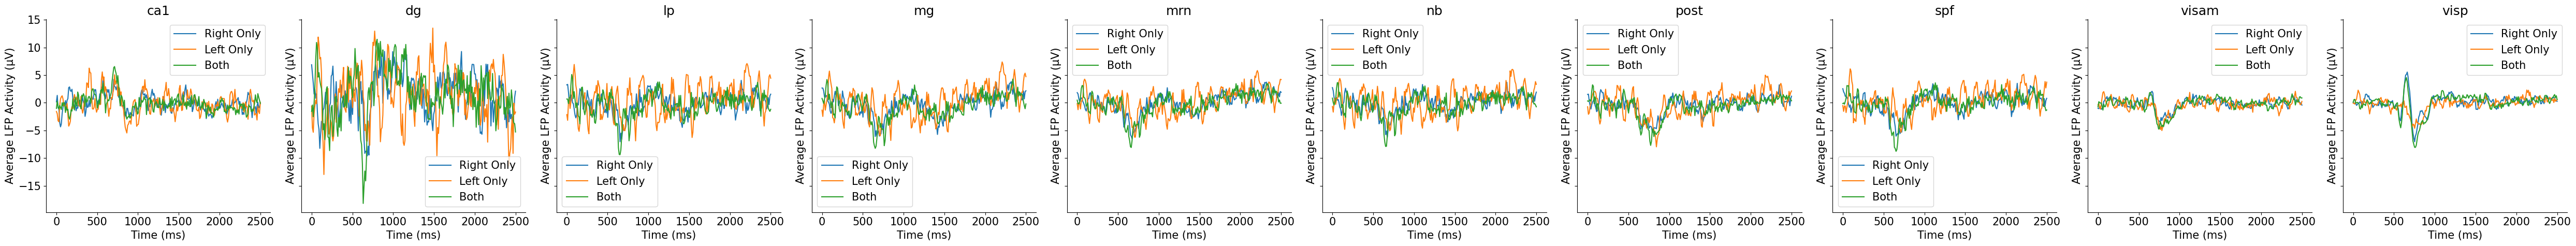

In [ ]:
# data prep s3
sessions = [cori_data[0], cori_data[1], cori_data[2]]
session = sessions[2]
lfp_data = session['lfp']  # shape: (n_channels, n_trials, n_timepoints)
vis_left_p = session['contrast_left']  # length: n_trials
vis_right_p = session['contrast_right']  # length: n_trials
regions = session['brain_area_lfp']  # length: n_channels
#unique_regions = np.unique(regions)  # unique brain areas
time = np.linspace(0, 2500, 250)  # Assuming 250 time points

right_only_mask = np.logical_and(vis_left_p == 0, vis_right_p > 0)
left_only_mask = np.logical_and(vis_left_p > 0, vis_right_p == 0)
both_mask = np.logical_and(vis_left_p > 0, vis_right_p > 0)


# Re-define unique_regions
unique_regions = np.unique([r.lower() for r in regions])

fig, axes = plt.subplots(1, len(unique_regions), figsize=(len(unique_regions) * 5, 5), sharey=True)

for j, region in enumerate(unique_regions):
    ax = axes[j]
    ax.set_title(region)

    region_indices = np.where([r.lower() == region for r in regions])[0]

    print(f"Processing region: {region}")
    print(f"Region indices: {region_indices}")

    for mask, label in zip([right_only_mask, left_only_mask, both_mask], ['Right Only', 'Left Only', 'Both']):
        if np.any(mask):
            if region_indices.size > 0:
                avg_lfp = np.mean(lfp_data[region_indices][:, mask, :], axis=1)  # mean across trials
                ax.plot(time, np.mean(avg_lfp, axis=0), label=label)  # Further average across channels if needed
            else:
                print(f"No data available for {label} in region {region}")
        else:
            print(f"No trials match the condition {label} in region {region}")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average LFP Activity (µV)')
    if len(ax.get_legend_handles_labels()[0]) > 0:  # Check if there are any legend entries to add
        ax.legend()

plt.tight_layout()
#save to png
plt.savefig("sides.png",transparent="true")
plt.show()

## average across all sessions (not wokring


In [ ]:

# Data preparation across all sessions
sessions = [cori_data[0], cori_data[1], cori_data[2]]

# Initialize containers for aggregated data
all_lfp_data = []
all_vis_left_p = []
all_vis_right_p = []
all_regions = []

# Aggregate data only for these common regions
for session in sessions:
    # Extract session specific data
    session_lfp_data = session['lfp']
    vis_left_p = session['contrast_left']
    vis_right_p = session['contrast_right']
    regions = session['brain_area_lfp']

    # Append data to the lists
    all_lfp_data.append(session_lfp_data)
    all_vis_left_p.append(vis_left_p)
    all_vis_right_p.append(vis_right_p)
    all_regions.extend(regions)

# Concatenate if there is any data
if all_lfp_data:
    all_lfp_data = np.concatenate(all_lfp_data, axis=1)  # Stack along the trial dimension
    all_vis_left_p = np.concatenate(all_vis_left_p)
    all_vis_right_p = np.concatenate(all_vis_right_p)
else:
    raise ValueError("No LFP data collected for common regions across sessions.")

# Time vector assumption
time = np.linspace(0, 2500, 250)

# Defining masks for visual conditions
right_only_mask = np.logical_and(all_vis_left_p == 0, all_vis_right_p > 0)
left_only_mask = np.logical_and(all_vis_left_p > 0, all_vis_right_p == 0)
both_mask = np.logical_and(all_vis_left_p > 0, all_vis_right_p > 0)

# Re-define unique regions (consider all regions)
unique_regions = np.unique([r.lower() for r in all_regions])

fig, axes = plt.subplots(1, len(unique_regions), figsize=(len(unique_regions) * 5, 5), sharey=True)

for j, region in enumerate(unique_regions):
    ax = axes[j]
    ax.set_title(region.capitalize())

    # Region-specific indices across all concatenated data
    region_indices = np.array([i for i, r in enumerate(all_regions) if r.lower() == region])

    for mask, label in zip([right_only_mask, left_only_mask, both_mask], ['Right Only', 'Left Only', 'Both']):
        if np.any(mask):
            filtered_indices = region_indices[np.nonzero(mask)]
            if filtered_indices.size > 0:
                avg_lfp = np.mean(all_lfp_data[filtered_indices], axis=1)  # mean across trials
                ax.plot(time, avg_lfp, label=label)
            else:
                print(f"No data available for {label} in region {region.capitalize()}")
        else:
            print(f"No trials match the condition {label} in region {region.capitalize()}")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average LFP Activity (µV)')
    if len(ax.get_legend_handles_labels()[0]) > 0:
        ax.legend()

plt.tight_layout()
# Save to png
plt.savefig("sides_across_common_sessions.png", transparent=True)
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 7 and the array at index 1 has size 4

# **Cross Correlation Analysis**

In [ ]:
#from scipy.signal import correlate
from scipy.stats import pearsonr

In [ ]:


sessions = [cori_data[0], cori_data[1], cori_data[2]]

# Function to identify and handle data for common regions between any two sessions
def process_common_regions(sessions):
    for i in range(len(sessions)):
        for j in range(i + 1, len(sessions)):
            common_regions = set(sessions[i]['brain_area_lfp']).intersection(set(sessions[j]['brain_area_lfp']))
            print(f"Overlapping areas between Session {i+1} and Session {j+1}: {list(common_regions)}")

            for region in common_regions:
                indices_i = [idx for idx, area in enumerate(sessions[i]['brain_area_lfp']) if area == region]
                indices_j = [idx for idx, area in enumerate(sessions[j]['brain_area_lfp']) if area == region]

                if len(indices_i) > 0 and len(indices_j) > 0:
                    data_i = np.mean(sessions[i]['lfp'][indices_i], axis=1)
                    data_j = np.mean(sessions[j]['lfp'][indices_j], axis=1)

                    if data_i.size > 1 and data_j.size > 1:  # Ensure there's enough data to compute correlation
                        correlation = np.corrcoef(data_i.flatten(), data_j.flatten())[0, 1]
                        print(f"Correlation for {region} between Session {i+1} and Session {j+1}: {correlation}")
                    else:
                        print(f"Not enough data to compute correlation for {region} between Session {i+1} and Session {j+1}")
                else:
                    print(f"Not enough data available for {region} in one of the sessions.")

process_common_regions(sessions)


Overlapping areas between Session 1 and Session 2: []
Overlapping areas between Session 1 and Session 3: ['VISp', 'DG']
Correlation for VISp between Session 1 and Session 3: 0.8573502337227071
Correlation for DG between Session 1 and Session 3: -0.14959869252253447
Overlapping areas between Session 2 and Session 3: ['POST', 'CA1']
Correlation for POST between Session 2 and Session 3: 0.6803166258776472
Correlation for CA1 between Session 2 and Session 3: 0.6373832341001698


**Inferences:**

- High Positive Correlation in VISp:

The high positive correlation (0.857) for the VISp region between Session 1 and Session 3 suggests a strong similarity in the patterns of brain activity in this region across these sessions. This implies that the experimental conditions or the state of the subjects might have been very similar during these sessions, at least with respect to the visual posterior region.

- Low Negative Correlation in DG:

The negative correlation (-0.150) in the dentate gyrus (DG) between Session 1 and Session 3 indicates a slight inverse relationship in the brain activity patterns. This could suggest that the conditions or tasks in these sessions had opposite effects on this region, although the correlation is quite weak, implying that the relationship isn't strongly inverse.

- Moderate Positive Correlation in POST and CA1:

The correlations in the POST (posterior area) and CA1 regions between Session 2 and Session 3 are moderately positive (0.680 and 0.637, respectively). This suggests a decent level of similarity in brain activity, which might indicate that similar tasks or states were induced in these sessions impacting these hippocampal and nearby regions.

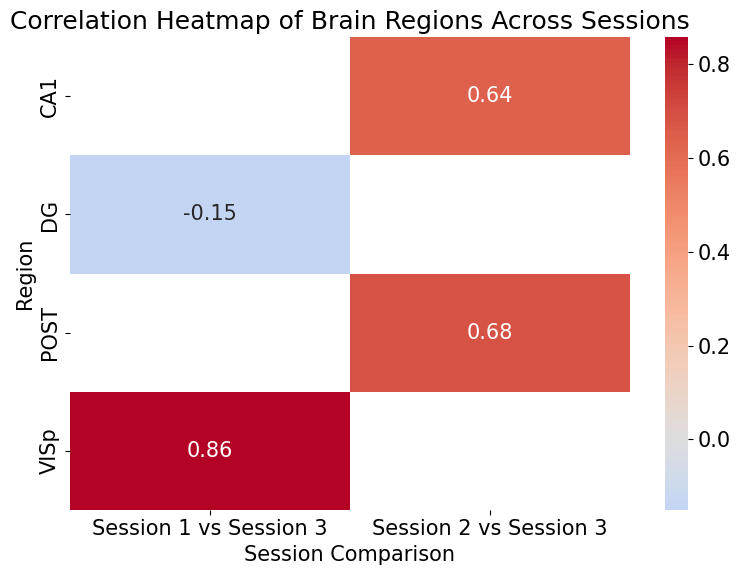

In [ ]:
correlations = {
    ('VISp', 'Session 1', 'Session 3'): 0.857,
    ('DG', 'Session 1', 'Session 3'): -0.150,
    ('POST', 'Session 2', 'Session 3'): 0.680,
    ('CA1', 'Session 2', 'Session 3'): 0.637
}

# Creating a DataFrame for plotting
data = []
for (region, sess1, sess2), corr in correlations.items():
    data.append([region, f"{sess1} vs {sess2}", corr])

df = pd.DataFrame(data, columns=['Region', 'Session Comparison', 'Correlation'])

# Pivot for heatmap
pivot_table = df.pivot(index='Region', columns='Session Comparison', values='Correlation')
# Adjust figure size
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Brain Regions Across Sessions')
plt.show()


In [ ]:

def extract_average_lfp_data(session, area):
    # Find indices of the specified area
    indices = [i for i, a in enumerate(session['brain_area_lfp']) if a == area]
    # Extract and average LFP data across all trials for each time bin
    if indices:
        lfp_data = session['lfp'][indices]
        return np.mean(lfp_data, axis=1)  # Averaging across trials
    else:
        return None

def plot_correlation(session1_data, session2_data, area, time):
    fig = go.Figure()

    # Add scatter plot trace
    fig.add_trace(go.Scatter(
        x=session1_data.flatten(),  # Flatten as we want to consider all time bins
        y=session2_data.flatten(),
        mode='markers',
        name=f'Correlation in {area}'
    ))

    # Update layout to make it more informative
    fig.update_layout(
        title=f'Correlation Scatter Plot for {area}',
        xaxis_title=f"Session 1 LFP Data ({area})",
        yaxis_title=f"Session 2 LFP Data ({area})",
        legend_title="Legend",
        height=600, width=800
    )

    fig.show()




In [ ]:
sessions = [cori_data[0], cori_data[1], cori_data[2]]
area = 'VISp'  # Example area
time = np.linspace(0, 2500, 250)  # Assuming 250 time points

# Extract LFP data for a specific area from two sessions
session1_data = extract_average_lfp_data(sessions[0], area)
session2_data = extract_average_lfp_data(sessions[2], area)

if session1_data is not None and session2_data is not None:
    plot_correlation(session1_data, session2_data, area, time)
else:
    print(f"Data not available for {area} in one of the selected sessions.")

In [ ]:
def plot_lfp_across_sessions(sessions, area, time):
    fig = go.Figure()

    colors = ['blue', 'red', 'green']  # Colors for different sessions
    session_labels = ['Session 1', 'Session 2', 'Session 3']

    # Loop through sessions and plot LFP data
    for idx, session in enumerate(sessions):
        lfp_data = extract_average_lfp_data(session, area)
        if lfp_data is not None:
            # Average across trials at each time point
            mean_lfp = np.mean(lfp_data, axis=0)
            fig.add_trace(go.Scatter(
                x=time,
                y=mean_lfp,
                mode='lines',
                name=f'{session_labels[idx]} (Mean LFP)',
                line=dict(color=colors[idx])
            ))

    # Update layout to make it more informative
    fig.update_layout(
        title=f'LFP Activity Across Sessions for {area}',
        xaxis_title="Time (ms)",
        yaxis_title="LFP (µV)",
        legend_title="Session",
        height=600, width=800
    )

    fig.show()

# Assuming sessions and area are defined as before
time = np.linspace(0, 2500, 250)  # Assuming 250 time points
plot_lfp_across_sessions(sessions, 'VISp', time)
